In [1]:
required_packages <- c(
"caret",
"MASS",
"randomForest",
"e1071",
"ggplot2",
"dplyr",
"corrplot",
"nnet",
"naivebayes",
"MVN",
"mgcv",
"devtools",
"moments",
"klaR",
"xgboost",
"C50"
)

# Function to install and load packages
install_and_load_packages <- function(packages) {
  cat("Checking and installing required packages...\n")
  
  for (package in packages) {
    if (!require(package, character.only = TRUE, quietly = TRUE)) {
      cat(sprintf("Installing package: %s\n", package))
      install.packages(package, dependencies = TRUE)
      if (!require(package, character.only = TRUE, quietly = TRUE)) {
        stop(sprintf("Package '%s' installation failed", package))
      }
    } else {
      cat(sprintf("Package '%s' is already installed and loaded\n", package))
    }
  }
  cat("\nAll required packages are installed and loaded!\n\n")
}

# Install and load all required packages
install_and_load_packages(required_packages)


Checking and installing required packages...
Package 'caret' is already installed and loaded
Package 'MASS' is already installed and loaded


randomForest 4.7-1.2

Type rfNews() to see new features/changes/bug fixes.


Attachement du package : 'randomForest'


L'objet suivant est masqué depuis 'package:ggplot2':

    margin




Package 'randomForest' is already installed and loaded
Package 'e1071' is already installed and loaded
Package 'ggplot2' is already installed and loaded



Attachement du package : 'dplyr'


L'objet suivant est masqué depuis 'package:randomForest':

    combine


L'objet suivant est masqué depuis 'package:MASS':

    select


Les objets suivants sont masqués depuis 'package:stats':

    filter, lag


Les objets suivants sont masqués depuis 'package:base':

    intersect, setdiff, setequal, union




Package 'dplyr' is already installed and loaded


corrplot 0.95 loaded



Package 'corrplot' is already installed and loaded
Package 'nnet' is already installed and loaded


naivebayes 1.0.0 loaded

For more information please visit: 

https://majkamichal.github.io/naivebayes/



Package 'naivebayes' is already installed and loaded
Package 'MVN' is already installed and loaded



Attachement du package : 'nlme'


L'objet suivant est masqué depuis 'package:dplyr':

    collapse


This is mgcv 1.9-1. For overview type 'help("mgcv-package")'.


Attachement du package : 'mgcv'


L'objet suivant est masqué depuis 'package:MVN':

    mvn


L'objet suivant est masqué depuis 'package:nnet':

    multinom




Package 'mgcv' is already installed and loaded
Package 'devtools' is already installed and loaded



Attachement du package : 'moments'


Les objets suivants sont masqués depuis 'package:e1071':

    kurtosis, moment, skewness




Package 'moments' is already installed and loaded


Warning message:
"le package 'klaR' a été compilé avec la version R 4.4.2"


Package 'klaR' is already installed and loaded


Warning message:
"le package 'xgboost' a été compilé avec la version R 4.4.2"

Attachement du package : 'xgboost'


L'objet suivant est masqué depuis 'package:dplyr':

    slice




Package 'xgboost' is already installed and loaded


Warning message:
"le package 'C50' a été compilé avec la version R 4.4.2"


Package 'C50' is already installed and loaded

All required packages are installed and loaded!



In [2]:
if (!requireNamespace("UBL", quietly = TRUE)) {
    devtools::install_github("paobranco/UBL")
} else {
    cat("Package 'UBL' is already installed.\n")
}

Package 'UBL' is already installed.


In [3]:
library(caret)
library(MASS)
library(randomForest)
library(naivebayes)
library(e1071)
library(ggplot2)
library(dplyr)
library(corrplot)
library(nnet)
library(MVN)
library(mgcv)
library(DMwR)
library(UBL)
library(devtools)
library(moments)
library(klaR)
library(xgboost)
library(C50)


Le chargement a nécessité le package : grid

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Le chargement a nécessité le package : MBA

Le chargement a nécessité le package : gstat

Le chargement a nécessité le package : automap

Le chargement a nécessité le package : sp



In [4]:
set.seed(123)
data <- read.table("a24_clas_app.txt", header = TRUE, sep=" ")
data <- data[sample(nrow(data)),]
data$y <- as.factor(data$y)

In [47]:
missing_values <- colSums(is.na(data))
missing_values <- missing_values[missing_values > 0]
if (length(missing_values) > 0) {
  cat("Missing values in the dataset:\n")
  print(missing_values)
} else {
  cat("No missing values in the dataset\n")
}

No missing values in the dataset


In [48]:
# Get correlation matrix for X1-X45
cor_matrix <- cor(data[,1:45])  # Assuming X1-X45 are columns 1-45

# Function to find high correlations
find_high_cors <- function(cor_matrix, threshold) {
  # Get upper triangle to avoid duplicates
  upper_tri <- upper.tri(cor_matrix)
  
  # Find pairs exceeding threshold
  high_cors <- which(abs(cor_matrix) > threshold & upper_tri, arr.ind = TRUE)
  
  # Return results in readable format
  result <- data.frame(
    Var1 = rownames(cor_matrix)[high_cors[,1]],
    Var2 = colnames(cor_matrix)[high_cors[,2]],
    Correlation = cor_matrix[high_cors]
  )
  
  return(result[order(abs(result$Correlation), decreasing = TRUE),])
}

# Print results for different thresholds
thresholds <- c(0.9, 0.8, 0.7, 0.6, 0.5, 0.4)
for(threshold in thresholds) {
  high_cors <- find_high_cors(cor_matrix, threshold)
  if (nrow(high_cors) > 0) {
    cat("\nCorrelations above", threshold, ":\n")
    print(high_cors)
    cat("\nNumber of pairs:", nrow(high_cors), "\n")
  }
  else {
    cat("\nNo correlations above", threshold, "\n")
  }
}


No correlations above 0.9 

No correlations above 0.8 

No correlations above 0.7 

No correlations above 0.6 

No correlations above 0.5 

No correlations above 0.4 


Normal variables based on Shapiro test:
[1] "X25" "X26" "X28" "X34" "X38"

Normal variables based on Skewness and Kurtosis:
 [1] "X25" "X26" "X28" "X29" "X34" "X35" "X36" "X37" "X38" "X45"


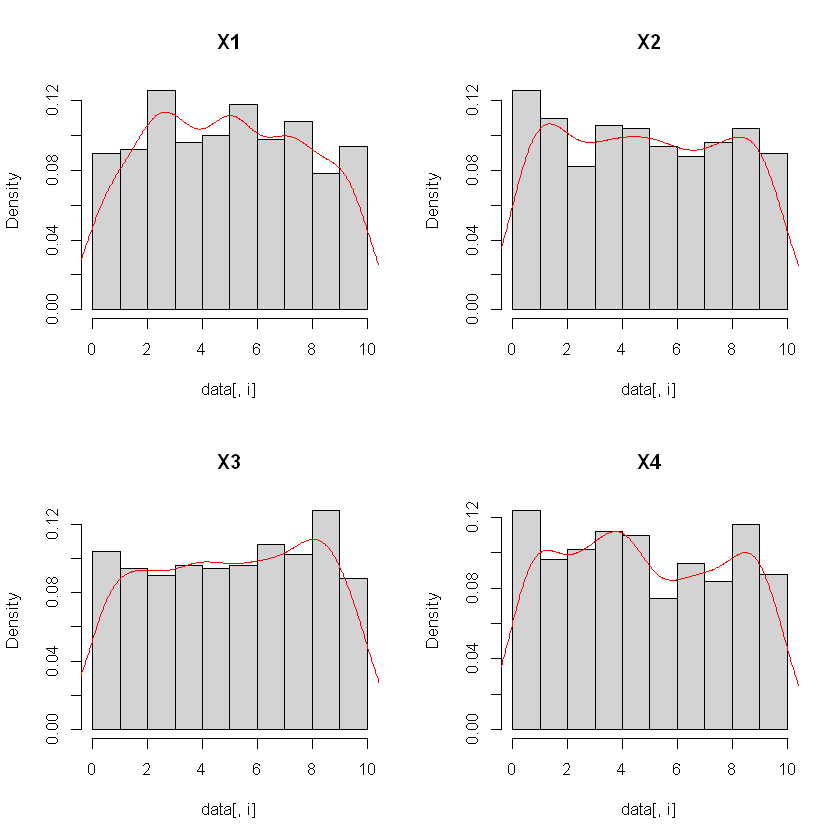

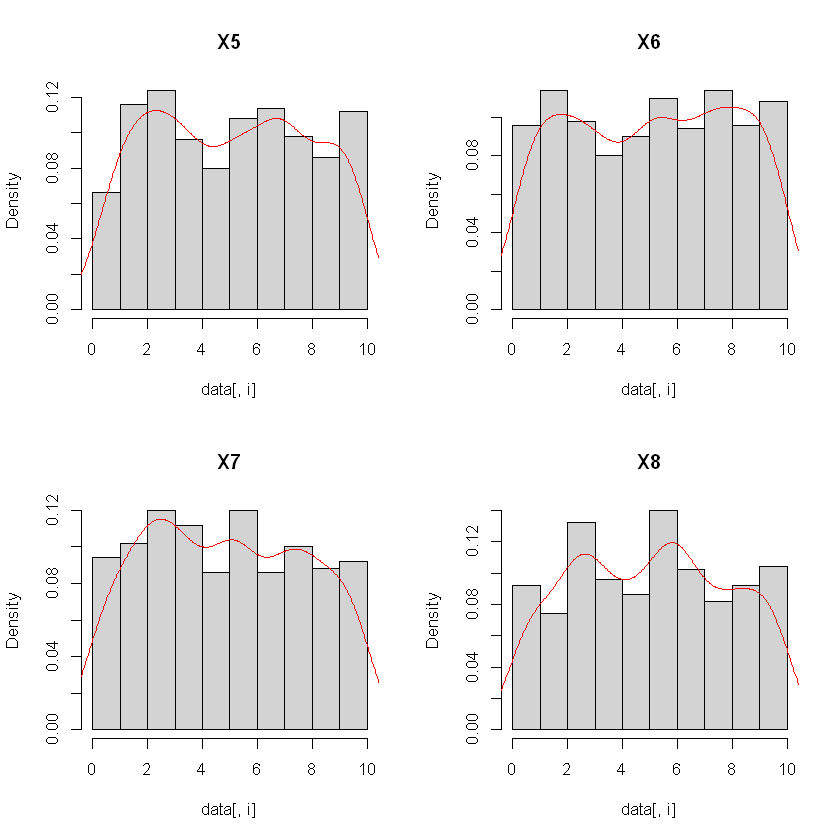

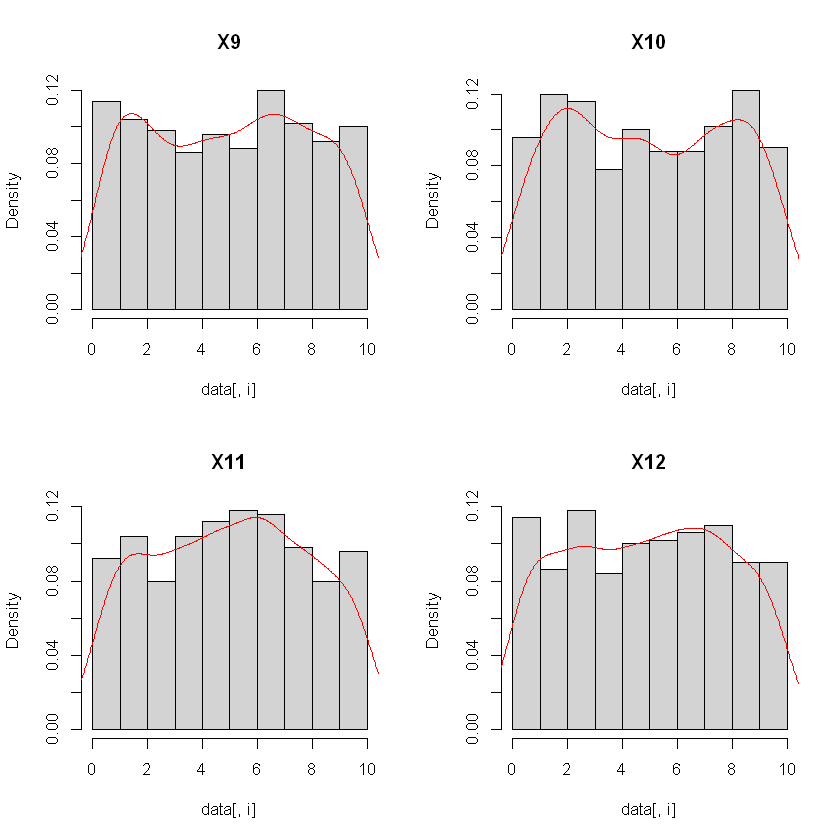

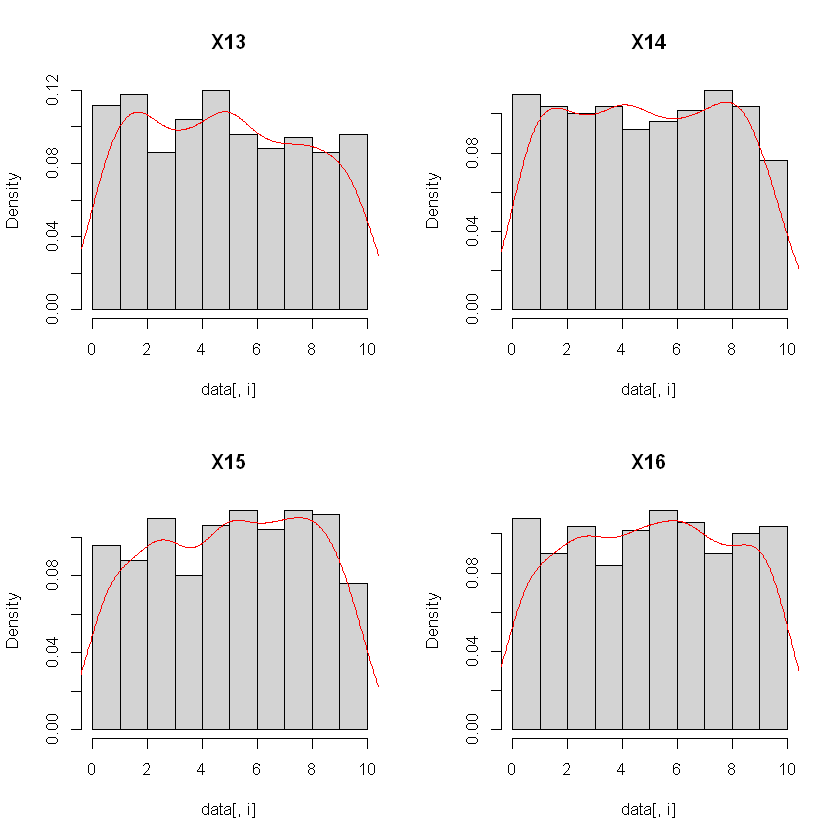

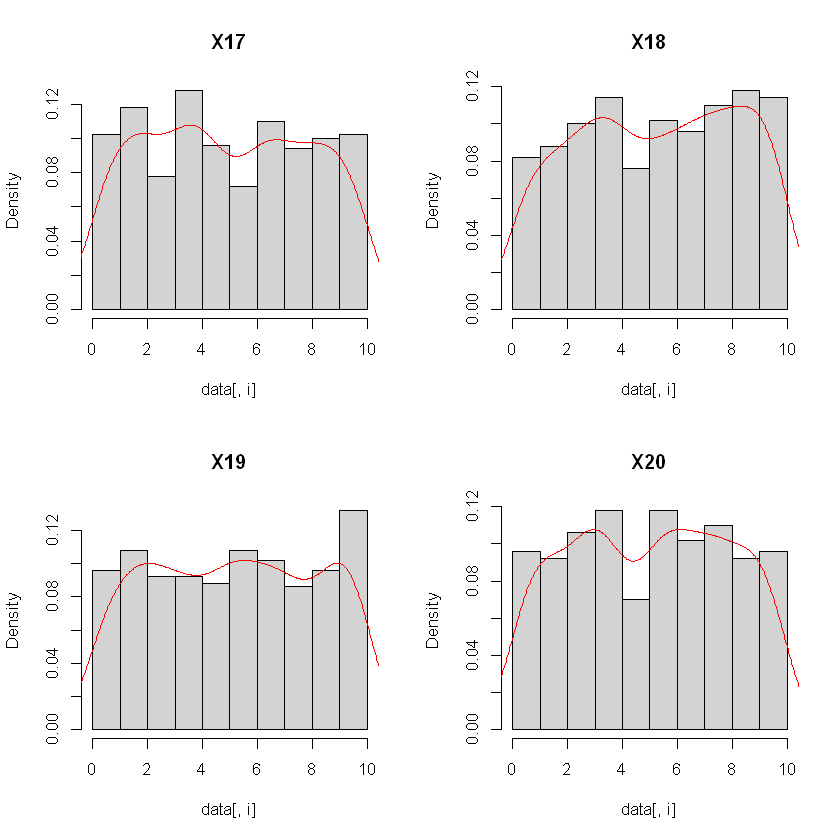

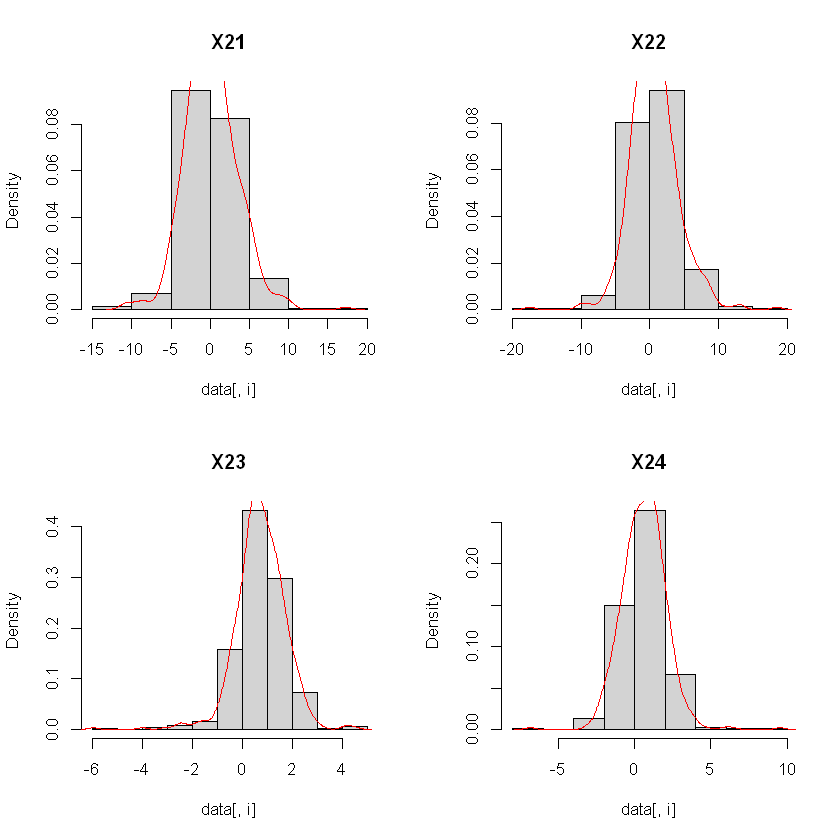

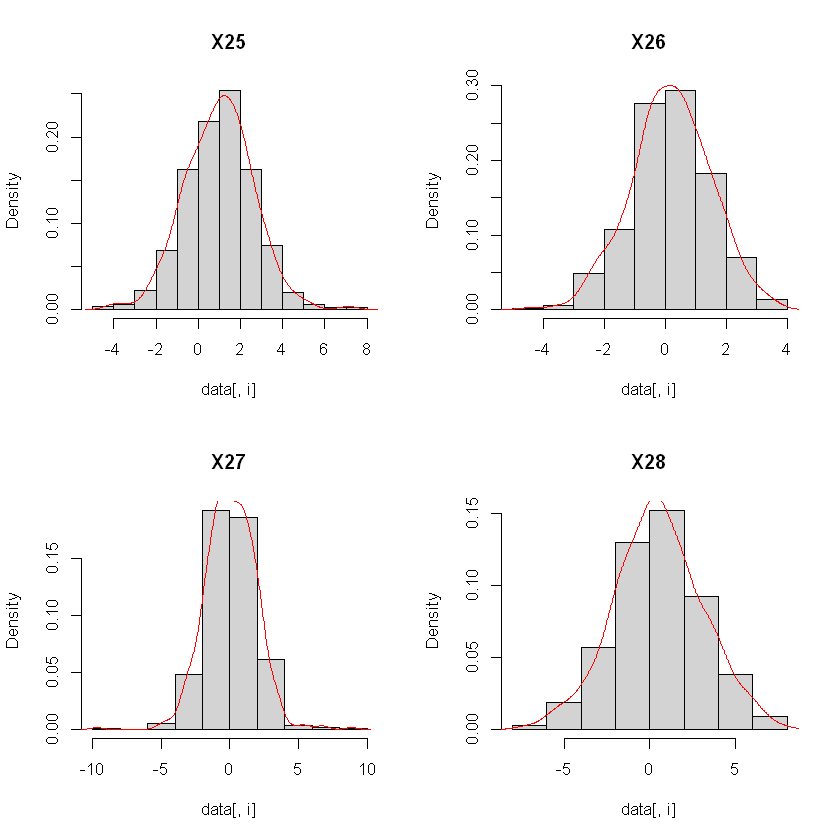

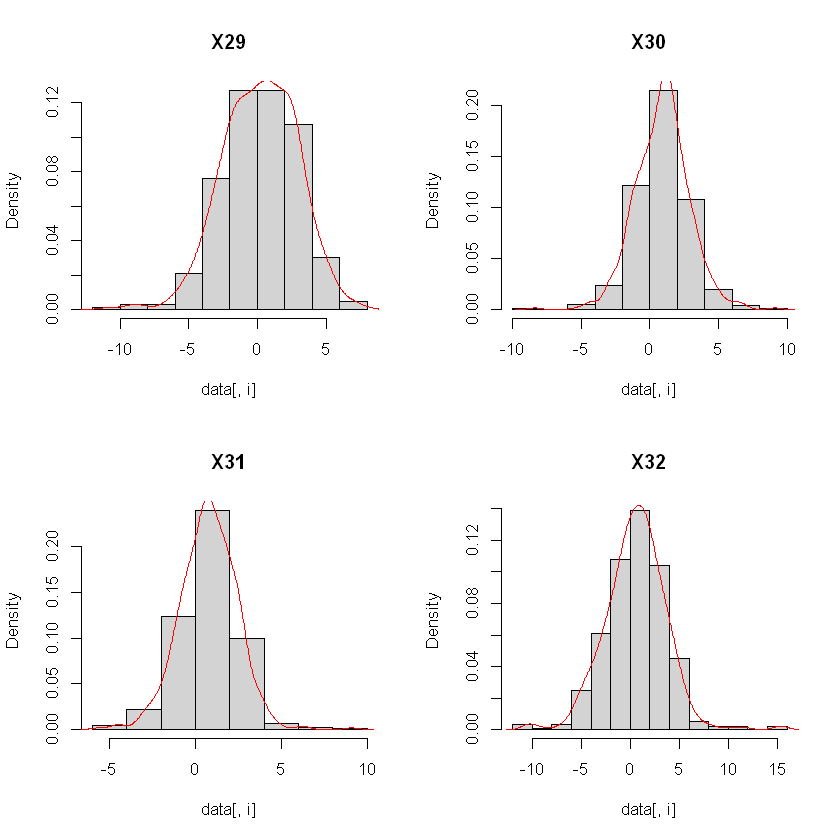

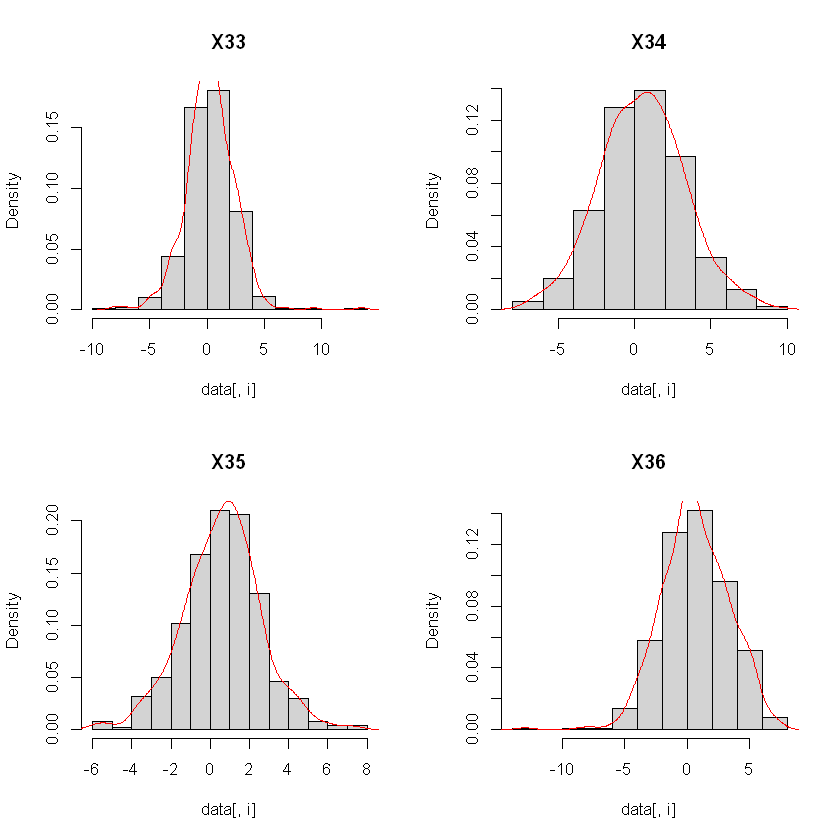

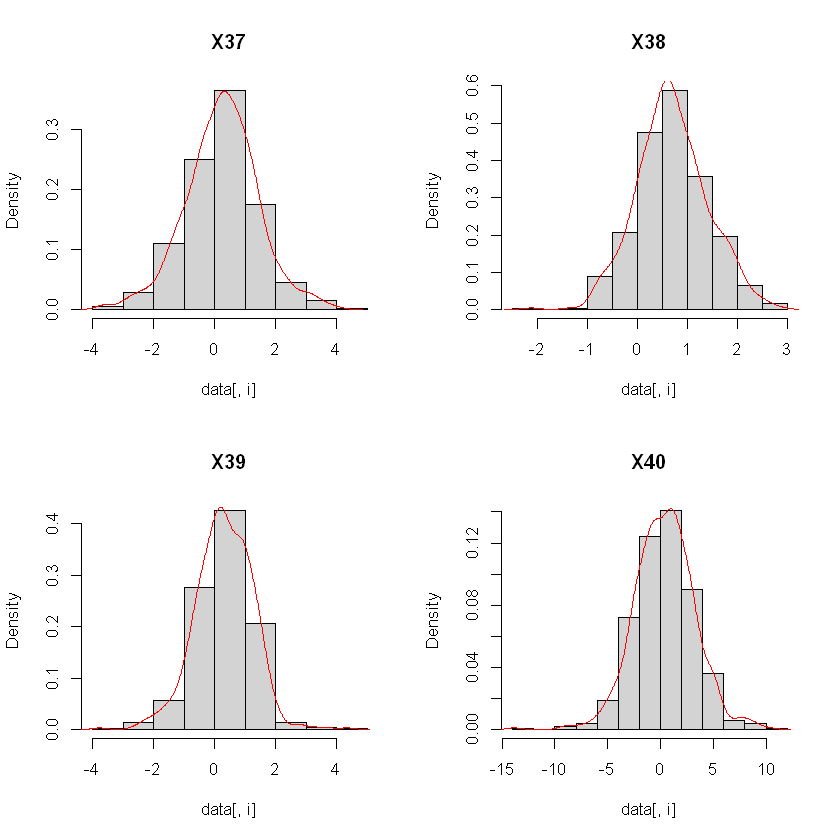

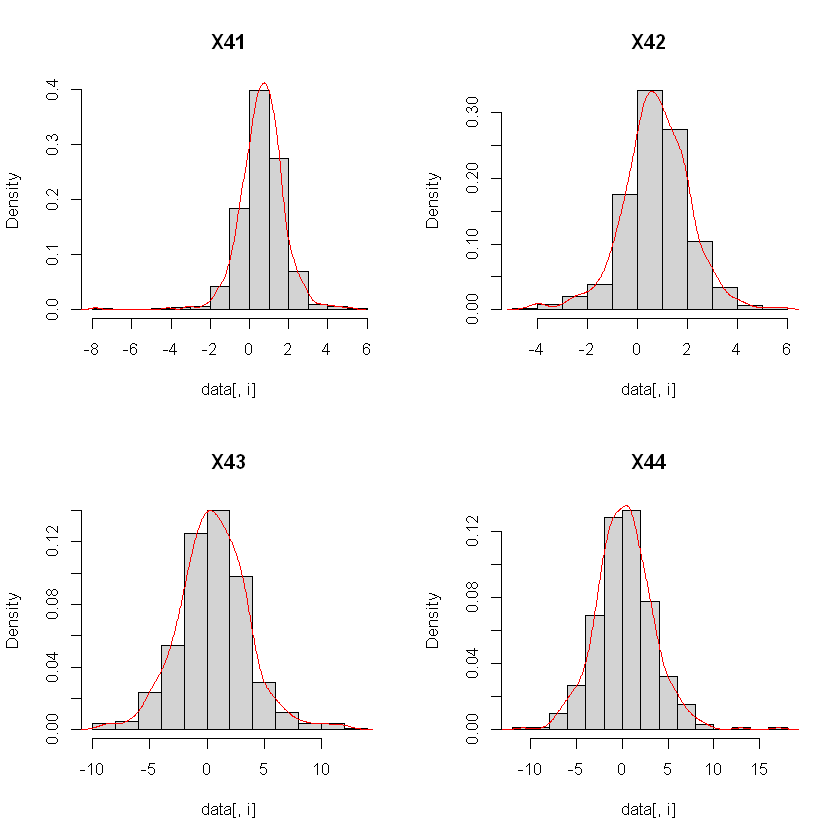

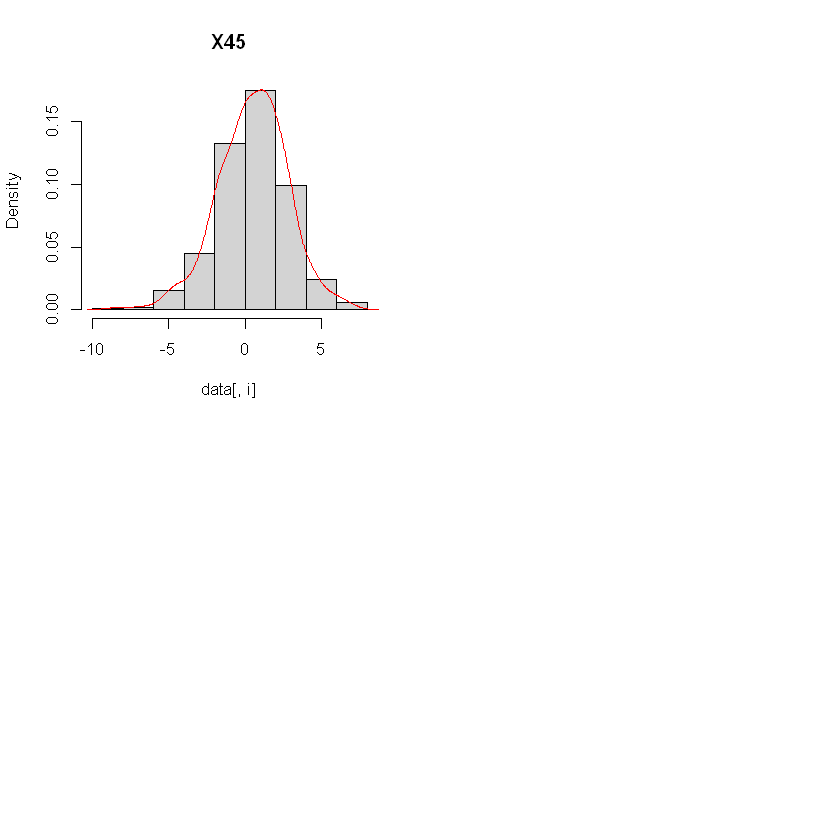

In [49]:
analyze_distributions <- function(data, vars = 1:45) {
  results <- data.frame(
    Variable = names(data)[vars],
    Skewness = NA,
    Kurtosis = NA,
    Shapiro_pvalue = NA,
    shapiro_Normality_Category = NA,
    Skewness_kurtosis_Category = NA,
    Skewness_kurtosis_Normality_Category = NA)
  
  for(i in seq_along(vars)) {
    var <- data[, vars[i]]
    sk <- skewness(var)
    kt <- kurtosis(var) - 3
    sw_p <- shapiro.test(var)$p.value
    
    if(abs(sk) <= 0.5 && abs(kt) <= 1) {
      category <- "Low Skewness & Kurtosis"
    } else if(abs(sk) <= 1 && abs(kt) <= 2) {
      category <- "Moderate Skewness & Kurtosis"
    } else if(abs(sk) <= 2 && abs(kt) <= 4) {
      category <- "High Skewness & Kurtosis"
    } else {
      category <- "Very High Skewness & Kurtosis"
    }
    
    results$Skewness[i] <- sk
    results$Kurtosis[i] <- kt
    results$Shapiro_pvalue[i] <- sw_p
    results$shapiro_Normality_Category[i] <- ifelse(sw_p < 0.05, "Non-Normal", "Normal")
    results$Skewness_kurtosis_Category[i] <- category
    results$Skewness_kurtosis_Normality_Category[i] <- ifelse(category == "Low Skewness & Kurtosis", "Normal", "Non-Normal")
  }
  
  return(results)
}

# Run analysis
results <- analyze_distributions(data)

cat("Normal variables based on Shapiro test:\n")
print(results$Variable[results$shapiro_Normality_Category == "Normal"])
# create a vector with variables that are normal based on Shapiro test
normal_sh_var <- results$Variable[results$shapiro_Normality_Category == "Normal"]
cat("\nNormal variables based on Skewness and Kurtosis:\n")
print(results$Variable[results$Skewness_kurtosis_Normality_Category == "Normal"])
# create a vector with variables that are normal based on Skewness and Kurtosis
normal_sk_var <- results$Variable[results$Skewness_kurtosis_Normality_Category == "Normal"]

normal_vi_var_naif <- c("X21", "X22", "X23", "X24", "X25", "X26", "X27", "X28", "X29", "X30", "X31", "X32", "X33", "X34", "X35", "X36", "X37", "X38", "X39", "X40", "X41", "X42", "X43", "X44", "X45")

# Optional: Create histograms with density curves for visual inspection
par(mfrow=c(2,2))
for(i in 1:45) {
  hist(data[,i], main=names(data)[i], probability=TRUE)
  lines(density(data[,i]), col="red")
}


Frequency table for X46 :

 0  1  2  3  4  5  6  7  8  9 10 11 12 
22 43 91 96 86 63 51 27 10  5  2  2  2 

Proportion table for X46 :

    0     1     2     3     4     5     6     7     8     9    10    11    12 
0.044 0.086 0.182 0.192 0.172 0.126 0.102 0.054 0.020 0.010 0.004 0.004 0.004 

Frequency table for X47 :

 0  1  2  3  4  5  6  7  8  9 10 11 
18 57 82 96 95 68 42 21 11  6  2  2 

Proportion table for X47 :

    0     1     2     3     4     5     6     7     8     9    10    11 
0.036 0.114 0.164 0.192 0.190 0.136 0.084 0.042 0.022 0.012 0.004 0.004 

Frequency table for X48 :

  0   1   2   3   4   5   6   7   8   9  10  11 
 16  49  92  89 101  72  30  21  18   8   1   3 

Proportion table for X48 :

    0     1     2     3     4     5     6     7     8     9    10    11 
0.032 0.098 0.184 0.178 0.202 0.144 0.060 0.042 0.036 0.016 0.002 0.006 

Frequency table for X49 :

 0  1  2  3  4  5  6  7  8  9 10 11 13 
16 49 89 88 93 60 42 31 13 12  4  2  1 

Proportion table f

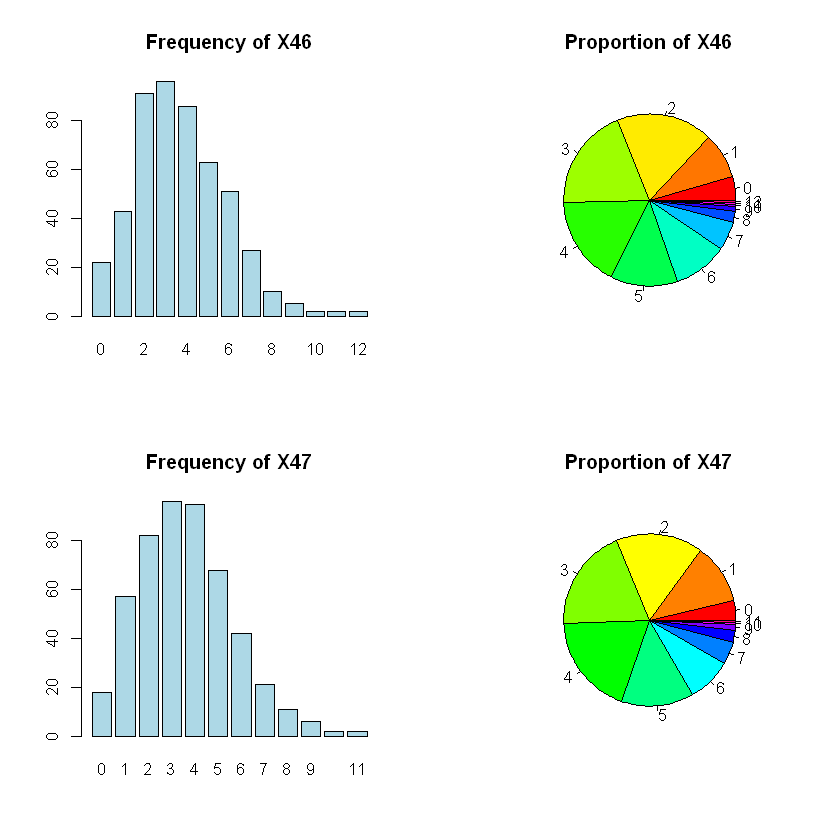

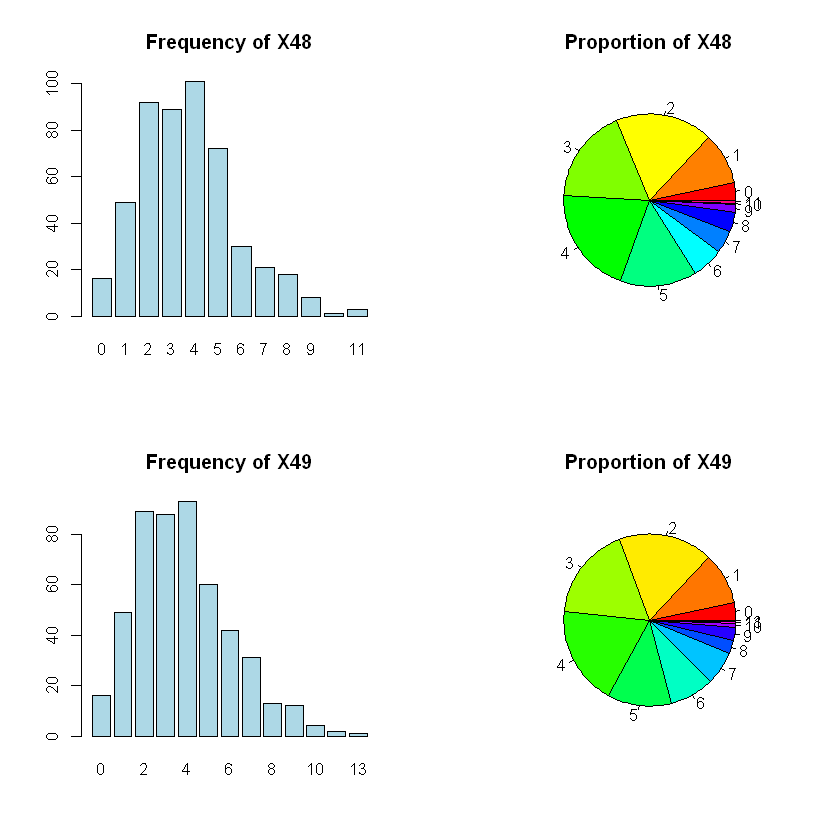

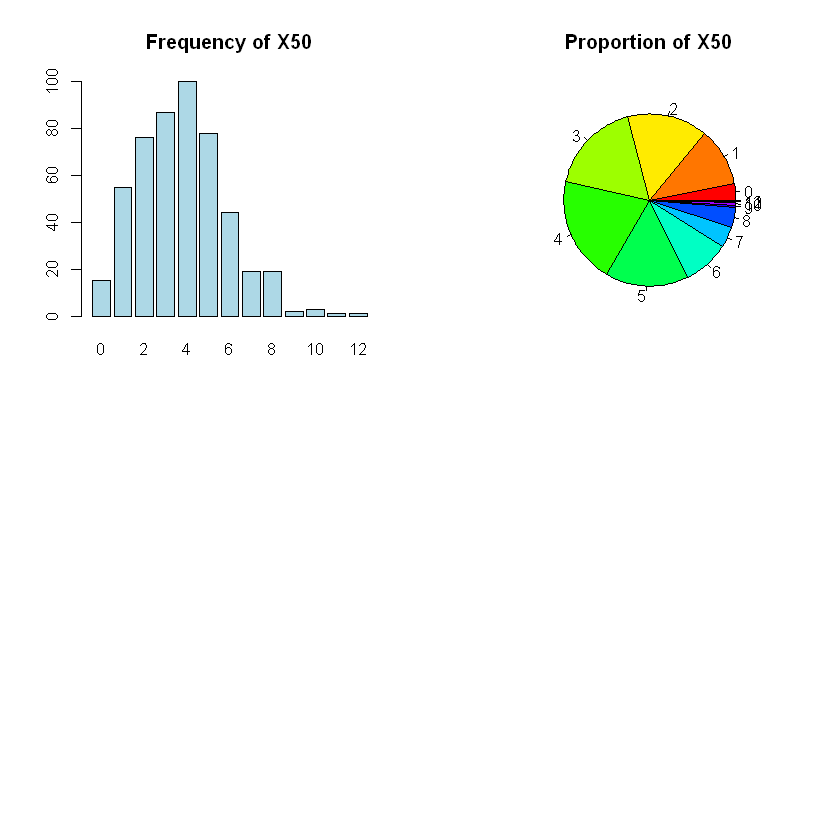

In [50]:
# Check frequency distributions
for(i in 46:50) {
    cat("\nFrequency table for", names(data)[i], ":\n")
    print(table(data[,i]))
    cat("\nProportion table for", names(data)[i], ":\n")
    print(prop.table(table(data[,i])))
}
# Plot frequency distributions
par(mfrow=c(2,2))
for(i in 46:50) {
    barplot(table(data[,i]), main=paste("Frequency of", names(data)[i]), col="lightblue")
    pie(table(data[,i]), main=paste("Proportion of", names(data)[i]), col=rainbow(length(unique(data[,i]))))
}

In [51]:
# Response variable distribution
table(data$y)
prop.table(table(data$y))


  1   2   3 
 82 227 191 


    1     2     3 
0.164 0.454 0.382 

In [52]:
# # Function to calculate Cramer's V
# calculate_cramers_v <- function(contingency_table) {
#     chi_square <- chisq.test(contingency_table)$statistic
#     n <- sum(contingency_table)
#     min_dim <- min(dim(contingency_table)) - 1
#     sqrt(chi_square / (n * min_dim))
# }

# # Enhanced analysis function
# analyze_categorical_vars <- function(data, cat_vars, response_var, 
#                                    p_value_threshold = 0.05,
#                                    cramers_v_threshold = 0.15) {
#     results <- list()
    
#     for(var in cat_vars) {
#         # Create contingency table
#         cont_table <- table(data[[var]], data[[response_var]])
        
#         # Chi-square test with simulation for robust p-values
#         chi_test <- chisq.test(cont_table, simulate.p.value = TRUE, B = 10000)
        
#         # Calculate Cramer's V
#         cramers_v <- calculate_cramers_v(cont_table)
        
#         # Calculate entropy-based measures
#         row_margins <- margin.table(cont_table, 1)
#         col_margins <- margin.table(cont_table, 2)
#         n <- sum(cont_table)
#         expected <- outer(row_margins, col_margins) / n
        
#         # Calculate standardized residuals
#         std_residuals <- (cont_table - expected) / sqrt(expected)
#         max_residual <- max(abs(std_residuals))
        
#         # Decision making criteria
#         is_significant <- chi_test$p.value < p_value_threshold
#         has_strong_association <- cramers_v > cramers_v_threshold
#         has_large_residuals <- max_residual > 2
        
#         # Final decision
#         keep_variable <- is_significant && (has_strong_association || has_large_residuals)
        
#         # Store results
#         results[[var]] <- list(
#             variable = var,
#             chi_square_p_value = chi_test$p.value,
#             cramers_v = cramers_v,
#             max_std_residual = max_residual,
#             significant = is_significant,
#             strong_association = has_strong_association,
#             large_residuals = has_large_residuals,
#             keep = keep_variable,
#             association_strength = case_when(
#                 cramers_v < 0.15 ~ "Weak",
#                 cramers_v < 0.25 ~ "Moderate",
#                 cramers_v < 0.35 ~ "Moderately Strong",
#                 TRUE ~ "Strong"
#             )
#         )
#     }
    
#     # Create summary data frame
#     summary_df <- do.call(rbind, lapply(results, function(x) {
#         data.frame(
#             Variable = x$variable,
#             P_Value = round(x$chi_square_p_value, 4),
#             Cramers_V = round(x$cramers_v, 4),
#             Max_Std_Residual = round(x$max_std_residual, 2),
#             Association = x$association_strength,
#             Keep = x$keep
#         )
#     }))
    
#     # Print detailed results
#     cat("\n=== CATEGORICAL VARIABLES ANALYSIS ===\n")
#     cat("\nDecision Criteria:")
#     cat(sprintf("\n- P-value threshold: %.3f", p_value_threshold))
#     cat(sprintf("\n- Cramer's V threshold: %.3f", cramers_v_threshold))
#     cat("\n- Large residual threshold: 2.0")
    
#     cat("\n\nResults Summary:\n")
#     print(summary_df)
    
#     cat("\nFINAL RECOMMENDATIONS:")
#     variables_to_keep <- summary_df$Variable[summary_df$Keep]
#     variables_to_drop <- summary_df$Variable[!summary_df$Keep]
    
#     cat("\nVariables to Keep:\n")
#     if(length(variables_to_keep) > 0) {
#         cat(paste(variables_to_keep, collapse = ", "))
#     } else {
#         cat("None")
#     }
    
#     cat("\n\nVariables to Drop:\n")
#     if(length(variables_to_drop) > 0) {
#         cat(paste(variables_to_drop, collapse = ", "))
#     } else {
#         cat("None")
#     }
    
#     # Create vector of variables to keep
#     cat("\n\nR code to create vector of variables to keep:\n")
#     if(length(variables_to_keep) > 0) {
#         cat(sprintf('categorical_vars_to_keep <- c("%s")', 
#                    paste(variables_to_keep, collapse = '", "')))
#     } else {
#         cat('categorical_vars_to_keep <- character(0)')
#     }
#     cat("\n")
    
#     # Return results invisibly for further use
#     invisible(list(
#         summary = summary_df,
#         variables_to_keep = variables_to_keep,
#         variables_to_drop = variables_to_drop
#     ))
# }

# # Usage
# categorical_vars <- paste0("X", 46:50)
# analysis_results <- analyze_categorical_vars(
#     data = data,
#     cat_vars = categorical_vars,
#     response_var = "y",
#     p_value_threshold = 0.05,
#     cramers_v_threshold = 0.15
# )

In [53]:
analyze_ordinal_correlations <- function(data, vars = 46:50, thresholds = seq(0.6, 0.9, by = 0.1)) {
    # Initialize results lists
    n_vars <- length(vars)
    var_names <- names(data)[vars]
    
    # Create matrices for correlations and p-values
    spearman_cor <- matrix(NA, n_vars, n_vars)
    spearman_p <- matrix(NA, n_vars, n_vars)
    kendall_cor <- matrix(NA, n_vars, n_vars)
    kendall_p <- matrix(NA, n_vars, n_vars)
    
    # Calculate correlations
    for(i in 1:n_vars) {
        for(j in 1:n_vars) {
            # Spearman correlation
            spearman_result <- cor.test(data[,vars[i]], data[,vars[j]], method = "spearman")
            spearman_cor[i,j] <- spearman_result$estimate
            spearman_p[i,j] <- spearman_result$p.value
            
            # Kendall correlation
            kendall_result <- cor.test(data[,vars[i]], data[,vars[j]], method = "kendall")
            kendall_cor[i,j] <- kendall_result$estimate
            kendall_p[i,j] <- kendall_result$p.value
        }
    }
    
    # Convert to data frames with variable names
    colnames(spearman_cor) <- rownames(spearman_cor) <- var_names
    colnames(kendall_cor) <- rownames(kendall_cor) <- var_names
    
    for (threshold in thresholds) {
        cat("\nThreshold:", threshold, "\n")
        
        # Find highly correlated pairs
        high_cor_pairs <- list()
        variables_to_remove <- character()
        
        for(i in 1:(n_vars-1)) {
            for(j in (i+1):n_vars) {
                if(abs(spearman_cor[i,j]) > threshold && spearman_p[i,j] < 0.05) {
                    pair <- c(var_names[i], var_names[j])
                    high_cor_pairs[[length(high_cor_pairs) + 1]] <- list(
                        vars = pair,
                        spearman_cor = spearman_cor[i,j],
                        spearman_p = spearman_p[i,j],
                        kendall_cor = kendall_cor[i,j],
                        kendall_p = kendall_p[i,j]
                    )
                    
                    # For each highly correlated pair, mark the second variable for removal
                    if(!(var_names[j] %in% variables_to_remove)) {
                        variables_to_remove <- c(variables_to_remove, var_names[j])
                    }
                }
            }
        }
        
        # Create vector of variables to keep
        variables_to_keep <- setdiff(var_names, variables_to_remove)
        
        # Print results
        cat("Highly correlated pairs (|ρ| >", threshold, "):\n")
        if(length(high_cor_pairs) > 0) {
            for(pair in high_cor_pairs) {
                cat(sprintf("\n%s & %s:\n", pair$vars[1], pair$vars[2]))
                cat(sprintf("Spearman ρ: %.3f (p = %.3e)\n", pair$spearman_cor, pair$spearman_p))
                cat(sprintf("Kendall τ: %.3f (p = %.3e)\n", pair$kendall_cor, pair$kendall_p))
            }
        } else {
            cat("No highly correlated pairs found.\n")
        }
        
        cat("\nVariables to keep:\n")
        print(variables_to_keep)
    }
    
    # Return results as a list
    return(list(
        spearman_cor = spearman_cor,
        kendall_cor = kendall_cor
    ))
}

# Usage example:
results <- analyze_ordinal_correlations(data)


Warning message in cor.test.default(data[, vars[i]], data[, vars[j]], method = "spearman"):
"Impossible de calculer la p-value exacte avec des ex-aequos"
Warning message in cor.test.default(data[, vars[i]], data[, vars[j]], method = "spearman"):
"Impossible de calculer la p-value exacte avec des ex-aequos"
Warning message in cor.test.default(data[, vars[i]], data[, vars[j]], method = "spearman"):
"Impossible de calculer la p-value exacte avec des ex-aequos"
Warning message in cor.test.default(data[, vars[i]], data[, vars[j]], method = "spearman"):
"Impossible de calculer la p-value exacte avec des ex-aequos"
Warning message in cor.test.default(data[, vars[i]], data[, vars[j]], method = "spearman"):
"Impossible de calculer la p-value exacte avec des ex-aequos"
Warning message in cor.test.default(data[, vars[i]], data[, vars[j]], method = "spearman"):
"Impossible de calculer la p-value exacte avec des ex-aequos"
Warning message in cor.test.default(data[, vars[i]], data[, vars[j]], method


Threshold: 0.6 
Highly correlated pairs (|ρ| > 0.6 ):
No highly correlated pairs found.

Variables to keep:
[1] "X46" "X47" "X48" "X49" "X50"

Threshold: 0.7 
Highly correlated pairs (|ρ| > 0.7 ):
No highly correlated pairs found.

Variables to keep:
[1] "X46" "X47" "X48" "X49" "X50"

Threshold: 0.8 
Highly correlated pairs (|ρ| > 0.8 ):
No highly correlated pairs found.

Variables to keep:
[1] "X46" "X47" "X48" "X49" "X50"

Threshold: 0.9 
Highly correlated pairs (|ρ| > 0.9 ):
No highly correlated pairs found.

Variables to keep:
[1] "X46" "X47" "X48" "X49" "X50"


In [5]:
# Create copies of original data
data_with_outliers <- data
data_cleaned <- data

# Define variable groups
continuous_vars <- paste0("X", 1:45)
ordinal_vars <- paste0("X", 46:50)

# Remove outliers for continuous variables only
for (var in continuous_vars) {
  Q1 <- quantile(data_cleaned[[var]], 0.25, na.rm = TRUE)
  Q3 <- quantile(data_cleaned[[var]], 0.75, na.rm = TRUE)
  IQR_val <- Q3 - Q1
  
  lower_bound <- Q1 - 1.5 * IQR_val
  upper_bound <- Q3 + 1.5 * IQR_val
  
  # Remove rows with outliers in any continuous variable
  data_cleaned <- data_cleaned[!(data_cleaned[[var]] < lower_bound | data_cleaned[[var]] > upper_bound), ]
}

# Calculate the ratio of rows deleted
cat("Rows deleted due to outliers:", (1 - nrow(data_cleaned) / nrow(data)) * 100, "%\n")

# Scale both datasets
# Dataset with outliers
preprocess_params_with_outliers <- preProcess(data_with_outliers[, continuous_vars], method = c("center", "scale"))
data_with_outliers_scaled <- data_with_outliers
data_with_outliers_scaled[, continuous_vars] <- predict(preprocess_params_with_outliers, data_with_outliers[, continuous_vars])

# Dataset without outliers
preprocess_params_cleaned <- preProcess(data_cleaned[, continuous_vars], method = c("center", "scale"))
data_cleaned_scaled <- data_cleaned
data_cleaned_scaled[, continuous_vars] <- predict(preprocess_params_cleaned, data_cleaned[, continuous_vars])

# Scale ordinal variables separately for both datasets
preprocess_params_ordinal_with_outliers <- preProcess(data_with_outliers[, ordinal_vars], method = c("center", "scale"))
data_with_outliers_scaled[, ordinal_vars] <- predict(preprocess_params_ordinal_with_outliers, data_with_outliers[, ordinal_vars])

preprocess_params_ordinal_cleaned <- preProcess(data_cleaned[, ordinal_vars], method = c("center", "scale"))
data_cleaned_scaled[, ordinal_vars] <- predict(preprocess_params_ordinal_cleaned, data_cleaned[, ordinal_vars])

# Store all versions in a list
datasets <- list(
  original_unscaled = data_with_outliers,
  original_scaled = data_with_outliers_scaled,
  clean_unscaled = data_cleaned,
  clean_scaled = data_cleaned_scaled
)

Rows deleted due to outliers: 27.6 %


In [69]:
# Model evaluation function (unchanged)
evaluate_model <- function(model, test_data, true_labels) {
  predictions <- predict(model, newdata = test_data)
  levels <- levels(true_labels)
  metrics <- multiClassSummary(data.frame(pred = predictions, obs = true_labels), lev = levels)
  return(list(
    Accuracy = metrics["Accuracy"],
    F1 = metrics["Mean_F1"]
  ))
}

# Function to apply sampling techniques (unchanged)
sample_data <- function(data, method = "none", unscaled=FALSE) {
  if (method == "smote") {
    data_balanced <- SmoteClassif(y ~ ., dat = data, C.perc = "balance")
    if (unscaled){
      data_balanced[,46:50] <- lapply(data_balanced[,46:50], round)
    }
  } else if (method == "up") {
    data_balanced <- RandOverClassif(y ~ ., dat = data, C.perc = "balance")
    if (unscaled){
      data_balanced[,46:50] <- lapply(data_balanced[,46:50], round)
    }
  } else if (method == "down") {
    data_balanced <- RandUnderClassif(y ~ ., dat = data, C.perc = "balance")
  } else {
    # No sampling
    data_balanced <- data
  }
  return(data_balanced)
}

set.seed(123)
sampling_methods <- c("none", "smote", "up", "down")
classification_method <- "naive_bayes"

# Initialize results dataframe
nb_results <- data.frame(
    Model = character(),
    Dataset = character(),
    Sampling_Method = character(),
    Fold = integer(),
    Accuracy = double(),
    F1 = double()
)

# For each dataset in the list
for (dataset_name in names(datasets)) {
    flag_unscaled <- dataset_name %in% c("original_unscaled", "clean_unscaled")
    dataset <- datasets[[dataset_name]]
    # Create 5 folds
    folds <- createFolds(dataset$y, k = 5, list = TRUE, returnTrain = FALSE)
    
    # For each fold
    for (fold_idx in 1:5) {
        # Split data into training and test sets
        test_indices <- folds[[fold_idx]]
        data_test <- dataset[test_indices, ]
        data_train <- dataset[-test_indices, ]
        
        # For each sampling method
        for (sampling_method in sampling_methods) {
            print(paste("Dataset:", dataset_name))
            print(paste("  Fold:", fold_idx))
            print(paste("    Sampling method:", sampling_method))
            flush.console()
            # Apply sampling to training data
            sampled_train <- sample_data(data_train, sampling_method,unscaled = flag_unscaled)
            # Train model
            model <- naiveBayes(y ~ ., data = sampled_train)
            
            # Evaluate on test set
            test_metrics <- evaluate_model(model, data_test, data_test$y)
            
            # Add results
            nb_results <- rbind(nb_results, data.frame(
                Model = classification_method,
                Dataset = dataset_name,
                Sampling_Method = sampling_method,
                Fold = fold_idx,
                Accuracy = test_metrics$Accuracy,
                F1 = test_metrics$F1
            ))
            rownames(nb_results) <- NULL
        }
    }
}


# Calculate mean metrics across folds
nb_summary_results <- aggregate(
    cbind(Accuracy,F1) ~ Model + Dataset + Sampling_Method,
    data = nb_results,
    FUN = function(x) c(mean = mean(x))
)

nb_final_results <-(list(
    nb_detailed_results = nb_results,
    nb_summary_results = nb_summary_results
))


[1] "Dataset: original_unscaled"
[1] "  Fold: 1"
[1] "    Sampling method: none"
[1] "Dataset: original_unscaled"
[1] "  Fold: 1"
[1] "    Sampling method: smote"
[1] "Dataset: original_unscaled"
[1] "  Fold: 1"
[1] "    Sampling method: up"
[1] "Dataset: original_unscaled"
[1] "  Fold: 1"
[1] "    Sampling method: down"
[1] "Dataset: original_unscaled"
[1] "  Fold: 2"
[1] "    Sampling method: none"
[1] "Dataset: original_unscaled"
[1] "  Fold: 2"
[1] "    Sampling method: smote"
[1] "Dataset: original_unscaled"
[1] "  Fold: 2"
[1] "    Sampling method: up"
[1] "Dataset: original_unscaled"
[1] "  Fold: 2"
[1] "    Sampling method: down"
[1] "Dataset: original_unscaled"
[1] "  Fold: 3"
[1] "    Sampling method: none"
[1] "Dataset: original_unscaled"
[1] "  Fold: 3"
[1] "    Sampling method: smote"
[1] "Dataset: original_unscaled"
[1] "  Fold: 3"
[1] "    Sampling method: up"
[1] "Dataset: original_unscaled"
[1] "  Fold: 3"
[1] "    Sampling method: down"
[1] "Dataset: original_unscaled

In [70]:
# Model evaluation function (unchanged)
evaluate_model <- function(model, test_data, true_labels) {
  predictions <- predict(model, newdata = test_data)$class
  levels <- levels(true_labels)
  metrics <- multiClassSummary(data.frame(pred = predictions, obs = true_labels), lev = levels)
  return(list(
    Accuracy = metrics["Accuracy"],
    F1 = metrics["Mean_F1"]
  ))
}

# Function to apply sampling techniques (unchanged)
sample_data <- function(data, method = "none", unscaled=FALSE) {
  if (method == "smote") {
    data_balanced <- SmoteClassif(y ~ ., dat = data, C.perc = "balance")
    if (unscaled){
      data_balanced[,46:50] <- lapply(data_balanced[,46:50], round)
    }
  } else if (method == "up") {
    data_balanced <- RandOverClassif(y ~ ., dat = data, C.perc = "balance")
    if (unscaled){
      data_balanced[,46:50] <- lapply(data_balanced[,46:50], round)
    }
  } else if (method == "down") {
    data_balanced <- RandUnderClassif(y ~ ., dat = data, C.perc = "balance")
  } else {
    # No sampling
    data_balanced <- data
  }
  return(data_balanced)
}

set.seed(123)
sampling_methods <- c("none", "smote", "up", "down")
classification_method <- "lda"

# Initialize results dataframe
lda_results <- data.frame(
    Model = character(),
    Dataset = character(),
    Sampling_Method = character(),
    Fold = integer(),
    Accuracy = double(),
    F1 = double()
)

# Define your Gaussian variable sets
gaussian_vars_sh <- c("X25", "X26", "X28", "X34", "X38")
gaussian_vars_sk <- c("X25", "X26", "X28", "X29", "X34", "X35", "X36", "X37", "X38", "X45")
gaussian_vars_his <- c("X21", "X22", "X23", "X24", "X25", "X26", "X27", "X28", "X29", "X30", "X31", "X32", "X33", "X34", "X35", "X36", "X37", "X38", "X39", "X40", "X41", "X42", "X43", "X44", "X45")

# Create list of variable sets to try
gaussian_sets <- list(
    sh = gaussian_vars_sh,
    sk = gaussian_vars_sk,
    his = gaussian_vars_his
)

# In your main loop, add a loop for Gaussian variable sets
for (dataset_name in names(datasets)) {
    flag_unscaled <- dataset_name %in% c("original_unscaled", "clean_unscaled")
    dataset <- datasets[[dataset_name]]
    
    # For each Gaussian variable set
    for (var_set_name in names(gaussian_sets)) {
        # Create the formula using only selected variables
        selected_vars <- gaussian_sets[[var_set_name]]
        formula_str <- paste("y ~", paste(selected_vars, collapse = " + "))
        current_formula <- as.formula(formula_str)
        # Update dataset name to track which variables were used
        current_dataset_name <- paste0(dataset_name, "_", var_set_name)
        
        # Rest of your existing nested loops for folds and sampling methods...
        for (fold_idx in 1:5) {
            test_indices <- folds[[fold_idx]]
            data_test <- dataset[test_indices, ]
            data_train <- dataset[-test_indices, ]
            
            for (sampling_method in sampling_methods) {
                print(paste("Fold:", fold_idx))
                print(paste("   Dataset:", current_dataset_name))
                print(paste("   Sampling method:", sampling_method))
                flush.console()
                
                sampled_train <- sample_data(data_train, sampling_method, unscaled = flag_unscaled)

                # Use the formula with selected variables
                model <- lda(current_formula, data = sampled_train)
                
                test_metrics <- evaluate_model(model, data_test, data_test$y)
                
                # Store results with updated dataset name
                lda_results <- rbind(lda_results, data.frame(
                    Model = classification_method,
                    Dataset = current_dataset_name, 
                    Sampling_Method = sampling_method,
                    Fold = fold_idx,
                    Accuracy = test_metrics$Accuracy,
                    F1 = test_metrics$F1
                ))
                rownames(lda_results) <- NULL
            }
        }
    }
}

# Calculate mean metrics across folds
lda_summary_results <- aggregate(
    cbind(Accuracy,F1) ~ Model + Dataset + Sampling_Method,
    data = lda_results,
    FUN = function(x) c(mean = mean(x))
)

lda_final_results <- list(
    lda_detailed_results = lda_results,
    lda_summary_results = lda_summary_results
)


[1] "Fold: 1"
[1] "   Dataset: original_unscaled_sh"
[1] "   Sampling method: none"
[1] "Fold: 1"
[1] "   Dataset: original_unscaled_sh"
[1] "   Sampling method: smote"
[1] "Fold: 1"
[1] "   Dataset: original_unscaled_sh"
[1] "   Sampling method: up"
[1] "Fold: 1"
[1] "   Dataset: original_unscaled_sh"
[1] "   Sampling method: down"
[1] "Fold: 2"
[1] "   Dataset: original_unscaled_sh"
[1] "   Sampling method: none"
[1] "Fold: 2"
[1] "   Dataset: original_unscaled_sh"
[1] "   Sampling method: smote"
[1] "Fold: 2"
[1] "   Dataset: original_unscaled_sh"
[1] "   Sampling method: up"
[1] "Fold: 2"
[1] "   Dataset: original_unscaled_sh"
[1] "   Sampling method: down"
[1] "Fold: 3"
[1] "   Dataset: original_unscaled_sh"
[1] "   Sampling method: none"
[1] "Fold: 3"
[1] "   Dataset: original_unscaled_sh"
[1] "   Sampling method: smote"
[1] "Fold: 3"
[1] "   Dataset: original_unscaled_sh"
[1] "   Sampling method: up"
[1] "Fold: 3"
[1] "   Dataset: original_unscaled_sh"
[1] "   Sampling method: d

In [71]:
# Model evaluation function (unchanged)
evaluate_model <- function(model, test_data, true_labels) {
  predictions <- predict(model, newdata = test_data)$class
  levels <- levels(true_labels)
  metrics <- multiClassSummary(data.frame(pred = predictions, obs = true_labels), lev = levels)
  return(list(
    Accuracy = metrics["Accuracy"],
    F1 = metrics["Mean_F1"]
  ))
}

# Function to apply sampling techniques (unchanged)
sample_data <- function(data, method = "none", unscaled=FALSE) {
  if (method == "smote") {
    data_balanced <- SmoteClassif(y ~ ., dat = data, C.perc = "balance")
    if (unscaled){
      data_balanced[,46:50] <- lapply(data_balanced[,46:50], round)
    }
  } else if (method == "up") {
    data_balanced <- RandOverClassif(y ~ ., dat = data, C.perc = "balance")
    if (unscaled){
      data_balanced[,46:50] <- lapply(data_balanced[,46:50], round)
    }
  } else if (method == "down") {
    data_balanced <- RandUnderClassif(y ~ ., dat = data, C.perc = "balance")
  } else {
    # No sampling
    data_balanced <- data
  }
  return(data_balanced)
}

set.seed(123)
sampling_methods <- c("smote", "up", "down")
classification_method <- "qda"

# Initialize results dataframe
qda_results <- data.frame(
    Model = character(),
    Dataset = character(),
    Sampling_Method = character(),
    Fold = integer(),
    Accuracy = double(),
    F1 = double()
)

# Define your Gaussian variable sets
gaussian_vars_sh <- c("X25", "X26", "X28", "X34", "X38")
gaussian_vars_sk <- c("X25", "X26", "X28", "X29", "X34", "X35", "X36", "X37", "X38", "X45")
gaussian_vars_his <- c("X21", "X22", "X23", "X24", "X25", "X26", "X27", "X28", "X29", "X30", "X31", "X32", "X33", "X34", "X35", "X36", "X37", "X38", "X39", "X40", "X41", "X42", "X43", "X44", "X45")

# Create list of variable sets to try
gaussian_sets <- list(
    sh = gaussian_vars_sh,
    sk = gaussian_vars_sk,
    his = gaussian_vars_his
)

# In your main loop, add a loop for Gaussian variable sets
for (dataset_name in names(datasets)) {
    flag_unscaled <- dataset_name %in% c("original_unscaled", "clean_unscaled")
    dataset <- datasets[[dataset_name]]
    
    # For each Gaussian variable set
    for (var_set_name in names(gaussian_sets)) {
        # Create the formula using only selected variables
        selected_vars <- gaussian_sets[[var_set_name]]
        formula_str <- paste("y ~", paste(selected_vars, collapse = " + "))
        current_formula <- as.formula(formula_str)
        # Update dataset name to track which variables were used
        current_dataset_name <- paste0(dataset_name, "_", var_set_name)
        
        # Rest of your existing nested loops for folds and sampling methods...
        for (fold_idx in 1:5) {
            test_indices <- folds[[fold_idx]]
            data_test <- dataset[test_indices, ]
            data_train <- dataset[-test_indices, ]
            
            for (sampling_method in sampling_methods) {
                print(paste("Fold:", fold_idx))
                print(paste("   Dataset:", current_dataset_name))
                print(paste("   Sampling method:", sampling_method))
                flush.console()
                
                sampled_train <- sample_data(data_train, sampling_method, unscaled = flag_unscaled)

                # Use the formula with selected variables
                model <- qda(current_formula, data = sampled_train)
                
                test_metrics <- evaluate_model(model, data_test, data_test$y)
                
                # Store results with updated dataset name
                qda_results <- rbind(qda_results, data.frame(
                    Model = classification_method,
                    Dataset = current_dataset_name, 
                    Sampling_Method = sampling_method,
                    Fold = fold_idx,
                    Accuracy = test_metrics$Accuracy,
                    F1 = test_metrics$F1
                ))
                rownames(qda_results) <- NULL
            }
        }
    }
}

# Calculate mean metrics across folds
qda_summary_results <- aggregate(
    cbind(Accuracy,F1) ~ Model + Dataset + Sampling_Method,
    data = qda_results,
    FUN = function(x) c(mean = mean(x))
)

qda_final_results <- list(
    qda_detailed_results = qda_results,
    qda_summary_results = qda_summary_results
)


[1] "Fold: 1"
[1] "   Dataset: original_unscaled_sh"
[1] "   Sampling method: smote"
[1] "Fold: 1"
[1] "   Dataset: original_unscaled_sh"
[1] "   Sampling method: up"
[1] "Fold: 1"
[1] "   Dataset: original_unscaled_sh"
[1] "   Sampling method: down"
[1] "Fold: 2"
[1] "   Dataset: original_unscaled_sh"
[1] "   Sampling method: smote"
[1] "Fold: 2"
[1] "   Dataset: original_unscaled_sh"
[1] "   Sampling method: up"
[1] "Fold: 2"
[1] "   Dataset: original_unscaled_sh"
[1] "   Sampling method: down"
[1] "Fold: 3"
[1] "   Dataset: original_unscaled_sh"
[1] "   Sampling method: smote"
[1] "Fold: 3"
[1] "   Dataset: original_unscaled_sh"
[1] "   Sampling method: up"
[1] "Fold: 3"
[1] "   Dataset: original_unscaled_sh"
[1] "   Sampling method: down"
[1] "Fold: 4"
[1] "   Dataset: original_unscaled_sh"
[1] "   Sampling method: smote"
[1] "Fold: 4"
[1] "   Dataset: original_unscaled_sh"
[1] "   Sampling method: up"
[1] "Fold: 4"
[1] "   Dataset: original_unscaled_sh"
[1] "   Sampling method: do

In [72]:
# Model evaluation function (unchanged)
evaluate_model <- function(model, test_data, true_labels) {
  predictions <- predict(model, newdata = test_data)$class
  levels <- levels(true_labels)
  metrics <- multiClassSummary(data.frame(pred = predictions, obs = true_labels), lev = levels)
  return(list(
    Accuracy = metrics["Accuracy"],
    F1 = metrics["Mean_F1"]
  ))
}

# Function to apply sampling techniques (unchanged)
sample_data <- function(data, method = "none", unscaled=FALSE) {
  if (method == "smote") {
    data_balanced <- SmoteClassif(y ~ ., dat = data, C.perc = "balance")
    if (unscaled){
      data_balanced[,46:50] <- lapply(data_balanced[,46:50], round)
    }
  } else if (method == "up") {
    data_balanced <- RandOverClassif(y ~ ., dat = data, C.perc = "balance")
    if (unscaled){
      data_balanced[,46:50] <- lapply(data_balanced[,46:50], round)
    }
  } else if (method == "down") {
    data_balanced <- RandUnderClassif(y ~ ., dat = data, C.perc = "balance")
  } else {
    # No sampling
    data_balanced <- data
  }
  return(data_balanced)
}
find_best_rda_params <- function(train_data, formula, dataset_name) {
    # Choose parameter ranges based on dataset type
    if(grepl("unscaled", dataset_name)) {
        lambdas <- seq(0, 0.3, by = 0.1)    # QDA-like
        gammas <- seq(0, 0.2, by = 0.05)

    } else {
        lambdas <- seq(0.7, 1, by = 0.1)    # LDA-like
        gammas <- seq(0, 0.2, by = 0.05)

    }
    
    best_params <- list(lambda=0, gamma=0, accuracy=0)
    
    for(l in lambdas) {
        for(g in gammas) {
            tryCatch({
                model <- rda(formula, data=train_data, gamma=g, lambda=l)
                preds <- predict(model, train_data)$class
                acc <- mean(preds == train_data$y)
                
                if(acc > best_params$accuracy) {
                    best_params <- list(lambda=l, gamma=g, accuracy=acc)
                }
            }, error=function(e) NULL)
        }
    }
    return(best_params)
}
set.seed(123)
sampling_methods <- c("smote", "up", "down")
classification_method <- "rda"

# Initialize results dataframe
rda_results <- data.frame(
    Model = character(),
    Dataset = character(),
    Sampling_Method = character(),
    Fold = integer(),
    Accuracy = double(),
    F1 = double()
)

# Define your Gaussian variable sets
gaussian_vars_sh <- c("X25", "X26", "X28", "X34", "X38")
gaussian_vars_sk <- c("X25", "X26", "X28", "X29", "X34", "X35", "X36", "X37", "X38", "X45")
gaussian_vars_his <- c("X21", "X22", "X23", "X24", "X25", "X26", "X27", "X28", "X29", "X30", "X31", "X32", "X33", "X34", "X35", "X36", "X37", "X38", "X39", "X40", "X41", "X42", "X43", "X44", "X45")

# Create list of variable sets to try
gaussian_sets <- list(
    sh = gaussian_vars_sh,
    sk = gaussian_vars_sk,
    his = gaussian_vars_his
)

# In your main loop, add a loop for Gaussian variable sets
for (dataset_name in names(datasets)) {
   flag_unscaled <- dataset_name %in% c("original_unscaled", "clean_unscaled")
   dataset <- datasets[[dataset_name]]
   
   # For each Gaussian variable set
   for (var_set_name in names(gaussian_sets)) {
       # Create the formula using only selected variables
       selected_vars <- gaussian_sets[[var_set_name]]
       formula_str <- paste("y ~", paste(selected_vars, collapse = " + "))
       current_formula <- as.formula(formula_str)
       
       # Update dataset name to track which variables were used
       current_dataset_name <- paste0(dataset_name, "_", var_set_name)
       
       # Find best parameters for this dataset and formula
       best_params <- find_best_rda_params(dataset, current_formula, dataset_name)
       
       # Create 5 folds
       folds <- createFolds(dataset$y, k = 5, list = TRUE, returnTrain = FALSE)
       
       # For each fold
       for (fold_idx in 1:5) {
           test_indices <- folds[[fold_idx]]
           data_test <- dataset[test_indices, ]
           data_train <- dataset[-test_indices, ]
           
           # For each sampling method (excluding 'none' for RDA)
           for (sampling_method in c("smote", "up", "down")) {
                print(paste("Fold:", fold_idx))
                print(paste("    Dataset:", current_dataset_name))
                print(paste("    Sampling method:", sampling_method))
                flush.console()
               # Apply sampling to training data
               sampled_train <- sample_data(data_train, sampling_method, unscaled = flag_unscaled)
               
               # Train RDA model with best parameters
               model <- rda(current_formula, data = sampled_train, 
                          gamma = best_params$gamma, 
                          lambda = best_params$lambda)
               
               # Evaluate on test set
               test_metrics <- evaluate_model(model, data_test, data_test$y)
               
               # Add results
               rda_results <- rbind(rda_results, data.frame(
                   Model = "rda",
                   Dataset = current_dataset_name,
                   Sampling_Method = sampling_method,
                   Fold = fold_idx,
                   Accuracy = test_metrics$Accuracy,
                   F1 = test_metrics$F1
               ))
               rownames(rda_results) <- NULL
           }
       }
   }
}

# Calculate mean metrics across folds
rda_summary_results <- aggregate(
    cbind(Accuracy,F1) ~ Model + Dataset + Sampling_Method,
    data = rda_results,
    FUN = function(x) c(mean = mean(x))
)

rda_final_results <- list(
    rda_detailed_results = rda_results,
    rda_summary_results = rda_summary_results
)


[1] "Fold: 1"
[1] "    Dataset: original_unscaled_sh"
[1] "    Sampling method: smote"
[1] "Fold: 1"
[1] "    Dataset: original_unscaled_sh"
[1] "    Sampling method: up"
[1] "Fold: 1"
[1] "    Dataset: original_unscaled_sh"
[1] "    Sampling method: down"
[1] "Fold: 2"
[1] "    Dataset: original_unscaled_sh"
[1] "    Sampling method: smote"
[1] "Fold: 2"
[1] "    Dataset: original_unscaled_sh"
[1] "    Sampling method: up"
[1] "Fold: 2"
[1] "    Dataset: original_unscaled_sh"
[1] "    Sampling method: down"
[1] "Fold: 3"
[1] "    Dataset: original_unscaled_sh"
[1] "    Sampling method: smote"
[1] "Fold: 3"
[1] "    Dataset: original_unscaled_sh"
[1] "    Sampling method: up"
[1] "Fold: 3"
[1] "    Dataset: original_unscaled_sh"
[1] "    Sampling method: down"
[1] "Fold: 4"
[1] "    Dataset: original_unscaled_sh"
[1] "    Sampling method: smote"
[1] "Fold: 4"
[1] "    Dataset: original_unscaled_sh"
[1] "    Sampling method: up"
[1] "Fold: 4"
[1] "    Dataset: original_unscaled_sh"
[1] 

In [74]:
# Model evaluation function (unchanged)
evaluate_model <- function(model, test_data, true_labels) {
  predictions <- predict(model, newdata = test_data)
  levels <- levels(true_labels)
  metrics <- multiClassSummary(data.frame(pred = predictions, obs = true_labels), lev = levels)
  return(list(
    Accuracy = metrics["Accuracy"],
    F1 = metrics["Mean_F1"]
  ))
}

# Function to apply sampling techniques (unchanged)
sample_data <- function(data, method = "none", unscaled=FALSE) {
  if (method == "smote") {
    data_balanced <- SmoteClassif(y ~ ., dat = data, C.perc = "balance")
    if (unscaled){
      data_balanced[,46:50] <- lapply(data_balanced[,46:50], round)
    }
  } else if (method == "up") {
    data_balanced <- RandOverClassif(y ~ ., dat = data, C.perc = "balance")
    if (unscaled){
      data_balanced[,46:50] <- lapply(data_balanced[,46:50], round)
    }
  } else if (method == "down") {
    data_balanced <- RandUnderClassif(y ~ ., dat = data, C.perc = "balance")
  } else {
    # No sampling
    data_balanced <- data
  }
  return(data_balanced)
}

set.seed(123)
sampling_methods <- c("none", "smote", "up", "down")
classification_method <- "rf"

# Initialize results dataframe
rf_results <- data.frame(
    Model = character(),
    Dataset = character(),
    Sampling_Method = character(),
    Fold = integer(),
    Accuracy = double(),
    F1 = double()
)

# For each dataset in the list
for (dataset_name in names(datasets)) {
    flag_unscaled <- dataset_name %in% c("original_unscaled", "clean_unscaled")
    dataset <- datasets[[dataset_name]]
    # Create 5 folds
    folds <- createFolds(dataset$y, k = 5, list = TRUE, returnTrain = FALSE)
    
    # For each fold
    for (fold_idx in 1:5) {
        # Split data into training and test sets
        test_indices <- folds[[fold_idx]]
        data_test <- dataset[test_indices, ]
        data_train <- dataset[-test_indices, ]
        
        # For each sampling method
        for (sampling_method in sampling_methods) {
            print(paste("Dataset:", dataset_name))
            print(paste("  Fold:", fold_idx))
            print(paste("    Sampling method:", sampling_method))
            flush.console()
            # Apply sampling to training data
            sampled_train <- sample_data(data_train, sampling_method,unscaled = flag_unscaled)
            # Train model
            model <- randomForest(
                    y ~ .,
                    data = sampled_train,
                    ntree = 500,        # Number of trees
                    mtry = 7,           # sqrt(50) rounded up for classification
                    nodesize = 5,       # Minimum size of terminal nodes
                    importance = TRUE   # Calculate variable importance
                  )
            
            # Evaluate on test set
            test_metrics <- evaluate_model(model, data_test, data_test$y)
            
            # Add results
            rf_results <- rbind(rf_results, data.frame(
                Model = classification_method,
                Dataset = dataset_name,
                Sampling_Method = sampling_method,
                Fold = fold_idx,
                Accuracy = test_metrics$Accuracy,
                F1 = test_metrics$F1
            ))
            rownames(rf_results) <- NULL
        }
    }
}


# Calculate mean metrics across folds
rf_summary_results <- aggregate(
    cbind(Accuracy,F1) ~ Model + Dataset + Sampling_Method,
    data = rf_results,
    FUN = function(x) c(mean = mean(x))
)

rf_final_results <-(list(
    rf_detailed_results = rf_results,
    rf_summary_results = rf_summary_results
))

[1] "Dataset: original_unscaled"
[1] "  Fold: 1"
[1] "    Sampling method: none"
[1] "Dataset: original_unscaled"
[1] "  Fold: 1"
[1] "    Sampling method: smote"
[1] "Dataset: original_unscaled"
[1] "  Fold: 1"
[1] "    Sampling method: up"
[1] "Dataset: original_unscaled"
[1] "  Fold: 1"
[1] "    Sampling method: down"
[1] "Dataset: original_unscaled"
[1] "  Fold: 2"
[1] "    Sampling method: none"
[1] "Dataset: original_unscaled"
[1] "  Fold: 2"
[1] "    Sampling method: smote"
[1] "Dataset: original_unscaled"
[1] "  Fold: 2"
[1] "    Sampling method: up"
[1] "Dataset: original_unscaled"
[1] "  Fold: 2"
[1] "    Sampling method: down"
[1] "Dataset: original_unscaled"
[1] "  Fold: 3"
[1] "    Sampling method: none"
[1] "Dataset: original_unscaled"
[1] "  Fold: 3"
[1] "    Sampling method: smote"
[1] "Dataset: original_unscaled"
[1] "  Fold: 3"
[1] "    Sampling method: up"
[1] "Dataset: original_unscaled"
[1] "  Fold: 3"
[1] "    Sampling method: down"
[1] "Dataset: original_unscaled

In [81]:
# Function to prepare data for XGBoost
prepare_xgb_data <- function(data) {
    # Convert features to matrix
    feature_matrix <- as.matrix(data[, !names(data) %in% "y"])
    
    # Convert labels to numeric (0-based)
    labels <- as.numeric(as.factor(data$y)) - 1
    
    return(list(
        features = feature_matrix,
        labels = labels
    ))
}


# Evaluation function for XGBoost
evaluate_xgb_model <- function(model, test_data, true_labels) {
    # Prepare test data
    test_prepared <- prepare_xgb_data(test_data)
    
    # Get predictions (returns probability matrix)
    pred_prob <- predict(model, test_prepared$features, reshape = TRUE)
    
    # Convert to class predictions (0-based)
    pred_classes <- max.col(pred_prob) - 1
    
    # Convert back to original labels for evaluation
    pred_classes <- levels(true_labels)[pred_classes + 1]
    pred_classes <- factor(pred_classes, levels = levels(true_labels))
    
    # Calculate metrics using caret's multiClassSummary
    pred_df <- data.frame(pred = pred_classes, obs = true_labels)
    metrics <- multiClassSummary(pred_df, lev = levels(true_labels))
    return(list(
    Accuracy = metrics["Accuracy"],
    F1 = metrics["Mean_F1"]
  ))
}

# Function to apply sampling techniques (unchanged)
sample_data <- function(data, method = "none", unscaled=FALSE) {
  if (method == "smote") {
    data_balanced <- SmoteClassif(y ~ ., dat = data, C.perc = "balance")
    if (unscaled){
      data_balanced[,46:50] <- lapply(data_balanced[,46:50], round)
    }
  } else if (method == "up") {
    data_balanced <- RandOverClassif(y ~ ., dat = data, C.perc = "balance")
    if (unscaled){
      data_balanced[,46:50] <- lapply(data_balanced[,46:50], round)
    }
  } else if (method == "down") {
    data_balanced <- RandUnderClassif(y ~ ., dat = data, C.perc = "balance")
  } else {
    # No sampling
    data_balanced <- data
  }
  return(data_balanced)
}

# Main execution
set.seed(123)
sampling_methods <- c("none", "smote", "up", "down")
classification_method <- "xgboost"  # Changed from rf to xgboost


# Initialize results dataframe
xgb_results <- data.frame(
    Model = character(),
    Dataset = character(),
    Sampling_Method = character(),
    Fold = integer(),
    Accuracy = double(),
    F1 = double()
)

# For each dataset in the list
for (dataset_name in names(datasets)) {
    flag_unscaled <- dataset_name %in% c("original_unscaled", "clean_unscaled")
    dataset <- datasets[[dataset_name]]
    
    # Update number of classes in XGBoost parameters
    xgb_params$num_class <- length(levels(dataset$y))
    
    # Create 5 folds
    folds <- createFolds(dataset$y, k = 5, list = TRUE, returnTrain = FALSE)
    
    # For each fold
    for (fold_idx in 1:5) {
        # Split data into training and test sets
        test_indices <- folds[[fold_idx]]
        data_test <- dataset[test_indices, ]
        data_train <- dataset[-test_indices, ]
        
        # For each sampling method
        for (sampling_method in sampling_methods) {
            print(paste("Dataset:", dataset_name))
            print(paste("  Fold:", fold_idx))
            print(paste("    Sampling method:", sampling_method))
            flush.console()
            
            # Apply sampling to training data
            sampled_train <- sample_data(data_train, sampling_method, unscaled = flag_unscaled)
            
            # Prepare data and train XGBoost model
            train_prepared <- prepare_xgb_data(sampled_train)
            model <- xgboost(
                data = train_prepared$features,
                label = train_prepared$labels,
                objective = "multi:softprob",
                eval_metric = "mlogloss",
                num_class = 3,
                min_child_weight = 3, 
                eta = 0.01,
                gamma = 1,               # Minimum loss reduction for split
                alpha = 0.1,             # L1 regularization
                lambda = 1,   
                max_depth = 8,
                nthread = 4,
                subsample = 0.8,
                colsample_bytree = 0.8,
                nrounds = 1000,
                early_stopping_rounds = 50,
                verbose = 0
            )
            
            # Evaluate on test set
            test_metrics <- evaluate_xgb_model(model, data_test,true_labels = data_test$y)
            
            # Add results
            xgb_results <- rbind(xgb_results, data.frame(
                Model = classification_method,
                Dataset = dataset_name,
                Sampling_Method = sampling_method,
                Fold = fold_idx,
                Accuracy = test_metrics$Accuracy,
                F1 = test_metrics$F1
            ))
            rownames(xgb_results) <- NULL
        }
    }
}

# Calculate mean metrics across folds
xgb_summary_results <- aggregate(
    cbind(Accuracy, F1) ~ Model + Dataset + Sampling_Method,
    data = xgb_results,
    FUN = function(x) c(mean = mean(x))
)

xgb_final_results <- list(
    xgb_detailed_results = xgb_results,
    xgb_summary_results = xgb_summary_results
)

[1] "Dataset: original_unscaled"
[1] "  Fold: 1"
[1] "    Sampling method: none"
[1] "Dataset: original_unscaled"
[1] "  Fold: 1"
[1] "    Sampling method: smote"
[1] "Dataset: original_unscaled"
[1] "  Fold: 1"
[1] "    Sampling method: up"
[1] "Dataset: original_unscaled"
[1] "  Fold: 1"
[1] "    Sampling method: down"
[1] "Dataset: original_unscaled"
[1] "  Fold: 2"
[1] "    Sampling method: none"
[1] "Dataset: original_unscaled"
[1] "  Fold: 2"
[1] "    Sampling method: smote"
[1] "Dataset: original_unscaled"
[1] "  Fold: 2"
[1] "    Sampling method: up"
[1] "Dataset: original_unscaled"
[1] "  Fold: 2"
[1] "    Sampling method: down"
[1] "Dataset: original_unscaled"
[1] "  Fold: 3"
[1] "    Sampling method: none"
[1] "Dataset: original_unscaled"
[1] "  Fold: 3"
[1] "    Sampling method: smote"
[1] "Dataset: original_unscaled"
[1] "  Fold: 3"
[1] "    Sampling method: up"
[1] "Dataset: original_unscaled"
[1] "  Fold: 3"
[1] "    Sampling method: down"
[1] "Dataset: original_unscaled

In [82]:
xgb_final_results$xgb_summary_results %>% arrange(desc(Accuracy)) %>% head(5)

,Model,Dataset,Sampling_Method,Accuracy,F1
,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,xgboost,original_scaled,none,0.6479250,0.5753248
2,xgboost,original_scaled,smote,0.6377036,0.5976718
3,xgboost,original_unscaled,none,0.6217708,0.5686449
4,xgboost,clean_unscaled,up,0.6215753,0.5694092
5,xgboost,original_scaled,up,0.6200034,0.5669947


In [15]:
# Function to perform a single RF iteration and get importance scores
get_rf_importance <- function(feature_data, response) {
  rf_select <- randomForest(
    x = feature_data,
    y = response,
    ntree = 5000,
    mtry = 8,
    nodesize = 2,
    replace = TRUE,
    sampsize = 400,
    importance = TRUE,
    localImp = TRUE,
    nPerm = 20
  )
  
  importance_scores <- importance(rf_select)
  data.frame(
    Variable = rownames(importance_scores),
    Importance = importance_scores[, "MeanDecreaseGini"]
  )
}

# Get importance-based feature tiers
get_feature_tiers <- function(dataset) {
  
  feature_data <- dataset[, 1:25]
  response <- dataset$y
  
  # Run RF iterations
  n_iterations <- 5
  importance_list <- list()
  for (i in 1:n_iterations) {
    importance_list[[i]] <- get_rf_importance(feature_data, response)
  }
  
  # Calculate stability and importance
  importance_matrix <- do.call(cbind, lapply(importance_list, function(x) x$Importance))
  stability_scores <- apply(importance_matrix, 1, function(x) sd(x) / mean(x))
  mean_importance <- rowMeans(importance_matrix)
  
  # Combine scores
  final_results <- data.frame(
    Variable = importance_list[[1]]$Variable,
    Combined_Score = mean_importance * (1 / (1 + stability_scores))
  )
  
  # Sort and get quantiles
  final_results <- final_results[order(final_results$Combined_Score, decreasing = TRUE), ]
  quantiles <- quantile(final_results$Combined_Score, probs = c(0.75, 0.85, 0.95))
  
  # Create vectors for each complexity tier
  complex_splines <- final_results$Variable[final_results$Combined_Score > quantiles[2]]
  moderate_splines <- final_results$Variable[final_results$Combined_Score > quantiles[1] & 
                                           final_results$Combined_Score <= quantiles[2]]
  simple_splines <- final_results$Variable[final_results$Combined_Score <= quantiles[1]]
   
  return(list(
    complex = complex_splines,
    moderate = moderate_splines,
    simple = simple_splines
  ))
}

# Function to generate GAM formulas with tiered complexity
generate_gam_formulas <- function(data,tiers) {

  # Create smooth terms with appropriate complexity
  print(tiers)
  flush.console()
  smooth_terms <- c(
    paste0("s(", tiers$complex, ", bs='tp', k=10)"), #Complex splines (k=8-10)
    paste0("s(", tiers$moderate, ", bs='tp', k=10)")  # Moderate splines (k=4-6)
    # paste0("s(", tiers$simple, ", bs='tp', k=5)")     # Simple splines (k=3)
  )
  
  # Other variables
  ordinal_vars <- names(data)[46:50]
  ordinal_terms <- paste0("s(", ordinal_vars, ", bs='cr')")
  qda_vars <- tail(names(data), 2)
  
  # Create formulas
  formula1 <- paste("y ~", paste(c(smooth_terms, ordinal_terms, qda_vars), collapse = " + "))
  formula2 <- paste("~", paste(c(smooth_terms, ordinal_terms, qda_vars), collapse = " + "))
  
  return(list(as.formula(formula1), as.formula(formula2)))
}
# Evaluation function for GAM (similar to your XGBoost evaluation)
evaluate_gam_model <- function(model, test_data, true_labels) {
    # Get predictions (returns probability matrix)
    pred_prob <- predict(model, newdata = test_data, type = "response")
    
    # Convert to class predictions (0-based)
    pred_classes <- max.col(pred_prob) - 1
    
    # Convert back to original labels for evaluation (like in your XGBoost code)
    pred_classes <- levels(true_labels)[pred_classes + 1]
    pred_classes <- factor(pred_classes, levels = levels(true_labels))
    
    # Calculate metrics using caret's multiClassSummary
    pred_df <- data.frame(pred = pred_classes, obs = true_labels)
    metrics <- multiClassSummary(pred_df, lev = levels(true_labels))
    return(list(
        Accuracy = metrics["Accuracy"],
        F1 = metrics["Mean_F1"]
    ))
}

# Function to apply sampling techniques (unchanged)
sample_data <- function(data, method = "none", unscaled=FALSE) {
  if (method == "smote") {
    data_balanced <- SmoteClassif(y ~ ., dat = data, C.perc = "balance")
    if (unscaled){
      data_balanced[,46:50] <- lapply(data_balanced[,46:50], round)
    }
  } else if (method == "up") {
    data_balanced <- RandOverClassif(y ~ ., dat = data, C.perc = "balance")
    if (unscaled){
      data_balanced[,46:50] <- lapply(data_balanced[,46:50], round)
    }
  } else if (method == "down") {
    data_balanced <- RandUnderClassif(y ~ ., dat = data, C.perc = "balance")
  } else {
    # No sampling
    data_balanced <- data
  }
  return(data_balanced)
}

set.seed(123)
sampling_methods <- c("up", "down")
classification_method <- "gam"

# Initialize results dataframe (same as your XGBoost code)
gam_results <- data.frame(
    Model = character(),
    Dataset = character(),
    Sampling_Method = character(),
    Fold = integer(),
    Accuracy = double(),
    F1 = double()
)
# For each dataset in the list
for (dataset_name in names(datasets)) {
  flag_unscaled <- dataset_name %in% c("original_unscaled", "clean_unscaled")
  dataset <- datasets[[dataset_name]]
  # Get feature tiers
  tiers <- get_feature_tiers(data)
  # Create 5 folds
  folds <- createFolds(dataset$y, k = 5, list = TRUE, returnTrain = FALSE)
  # For each fold
  for (fold_idx in 1:5) {
    # Split data into training and test sets
    test_indices <- folds[[fold_idx]]
    data_test <- dataset[test_indices, ]
    data_train <- dataset[-test_indices, ]
    # For each sampling method
    for (sampling_method in sampling_methods) {
      print(paste("Dataset:", dataset_name))
      print(paste("  Fold:", fold_idx))
      print(paste("    Sampling method:", sampling_method))
      flush.console()
      # Apply sampling to training data
      sampled_train <- sample_data(data_train, sampling_method, unscaled = flag_unscaled)
      
      # Store original test labels for evaluation
      original_test_labels <- data_test$y
      
      # Train QDA model on sampled training data
      gaussian_cols <- 26:45
      qda_model <- qda(y ~ ., data=sampled_train[,c(gaussian_cols, ncol(sampled_train))])
      
      # Get QDA probabilities for both train and test
      train_qda_probs <- predict(qda_model)$posterior
      test_qda_probs <- predict(qda_model, newdata=data_test)$posterior
      
      # Add small constant to avoid numerical issues
      train_qda_probs <- train_qda_probs + 1e-10
      test_qda_probs <- test_qda_probs + 1e-10
      
      # Add QDA probabilities to both datasets
      colnames(train_qda_probs) <- c("qd0", "qd1", "qd2")
      colnames(test_qda_probs) <- c("qd0", "qd1", "qd2")
      
      sampled_train <- cbind(sampled_train, train_qda_probs)
      data_test <- cbind(data_test, test_qda_probs)

      # Convert y to 0-based integer
      data_test$y <- as.integer(data_test$y)
      data_test$y <- data_test$y - 1
      sampled_train$y <- as.integer(sampled_train$y)
      sampled_train$y <- sampled_train$y - 1
      
      prepared_train <- sampled_train
      prepared_test <- data_test
      
      # Generate formulas
      formulas <- generate_gam_formulas(prepared_train,tiers)
      # Fit GAM model
      model <- gam(formulas, 
        family = multinom(K=2),  # for 3 classes (0,1,2)
        data = prepared_train)
      
      # Evaluate using original labels
      test_metrics <- evaluate_gam_model(model, prepared_test, original_test_labels)
      
      # Add results
      gam_results <- rbind(gam_results, data.frame(
        Model = classification_method,
        Dataset = dataset_name,
        Sampling_Method = sampling_method,
        Fold = fold_idx,
        Accuracy = test_metrics$Accuracy,
        F1 = test_metrics$F1
      ))
      rownames(gam_results) <- NULL
      print(gam_results)
      flush.console()
      
      # Break after first fold, first dataset, one sampling method
      break
    }
    break
  }
  break
}

# Calculate mean metrics across folds (same as your XGBoost code)
gam_summary_results <- aggregate(
    cbind(Accuracy, F1) ~ Model + Dataset + Sampling_Method,
    data = gam_results,
    FUN = function(x) c(mean = mean(x))
)

gam_final_results <- list(
    gam_detailed_results = gam_results,
    gam_summary_results = gam_summary_results)

[1] "Dataset: original_unscaled"
[1] "  Fold: 1"
[1] "    Sampling method: up"
$complex
[1] "X23" "X3"  "X22" "X4" 

$moderate
[1] "X15" "X1" 

$simple
 [1] "X13" "X6"  "X25" "X12" "X9"  "X24" "X10" "X21" "X7"  "X2"  "X17" "X19"
[13] "X5"  "X14" "X20" "X11" "X18" "X16" "X8" 

  Model           Dataset Sampling_Method Fold Accuracy        F1
1   gam original_unscaled              up    1     0.64 0.5907109


In [8]:
# Function to perform a single RF iteration and get importance scores
get_rf_importance <- function(feature_data, response) {
  rf_select <- randomForest(
    x = feature_data,
    y = response,
    ntree = 5000,    
    mtry = 8,
    nodesize = 2,
    replace = TRUE,
    sampsize = 400,
    importance = TRUE,
    localImp = TRUE,
    nPerm = 20
  )
  
  importance_scores <- importance(rf_select)
  data.frame(
    Variable = rownames(importance_scores),
    Importance = importance_scores[, "MeanDecreaseGini"]
  )
}

# Function to calculate stability score
calculate_stability_score <- function(importance_matrix) {
  cv <- apply(importance_matrix, 1, function(x) sd(x) / mean(x))
  return(cv)
}

for (dataset_name in names(datasets)) {
  dataset <- datasets[[dataset_name]]
  feature_data <- dataset[, 1:25]
  response <- dataset$y
  
  n_iterations <- 5
  importance_list <- list()
  
  print(paste("Starting analysis for dataset:", dataset_name))
  flush.console()
  
  # Perform multiple RF iterations with progress updates
  for (i in 1:n_iterations) {
    print(paste("Running iteration", i, "of", n_iterations))
    flush.console()
    
    importance_list[[i]] <- get_rf_importance(feature_data, response)
  }
  
  print("Calculating final results...")
  flush.console()
  
  # Process results
  importance_matrix <- do.call(cbind, lapply(importance_list, function(x) x$Importance))
  stability_scores <- calculate_stability_score(importance_matrix)
  mean_importance <- rowMeans(importance_matrix)
  
  final_results <- data.frame(
    Variable = importance_list[[1]]$Variable,
    Mean_Importance = mean_importance,
    Stability_Score = stability_scores
  )
  
  final_results$Combined_Score <- final_results$Mean_Importance * (1 / (1 + final_results$Stability_Score))
  final_results <- final_results[order(final_results$Combined_Score, decreasing = TRUE), ]
  
  quantiles <- quantile(final_results$Combined_Score, probs = c(0.75, 0.85, 0.95))
  final_results$Tier <- cut(final_results$Combined_Score,
    breaks = c(-Inf, quantiles[1], quantiles[2], quantiles[3], Inf),
    labels = c("Low", "Medium", "High", "Very High")
  )
  
  # Print results in a simple format
  print("=== FINAL RESULTS ===")
  print(paste("Dataset:", dataset_name))
  print(paste("Number of iterations:", n_iterations))
  print("-------------------")
  
  for(current_tier in c("Very High", "High", "Medium", "Low")) {
    tier_vars <- final_results[final_results$Tier == current_tier, ]
    print(paste(current_tier, "Importance Tier:"))
    if(nrow(tier_vars) > 0) {
      print(tier_vars[, c("Variable", "Mean_Importance", "Stability_Score")])
    }
    print("-------------------")
  }
  
  flush.console()
  break
}

[1] "Starting analysis for dataset: original_unscaled"
[1] "Running iteration 1 of 10"
[1] "Running iteration 2 of 10"
[1] "Running iteration 3 of 10"
[1] "Running iteration 4 of 10"
[1] "Running iteration 5 of 10"
[1] "Running iteration 6 of 10"
[1] "Running iteration 7 of 10"
[1] "Running iteration 8 of 10"
[1] "Running iteration 9 of 10"
[1] "Running iteration 10 of 10"
[1] "Calculating final results..."
[1] "=== FINAL RESULTS ==="
[1] "Dataset: original_unscaled"
[1] "Number of iterations: 10"
[1] "-------------------"
[1] "Very High Importance Tier:"
   Variable Mean_Importance Stability_Score
23      X23        15.04649     0.006238488
3        X3        11.95097     0.006620431
[1] "-------------------"
[1] "High Importance Tier:"
   Variable Mean_Importance Stability_Score
22      X22        11.44324     0.008514198
4        X4        10.48211     0.007421625
[1] "-------------------"
[1] "Medium Importance Tier:"
   Variable Mean_Importance Stability_Score
15      X15       10

clean until here

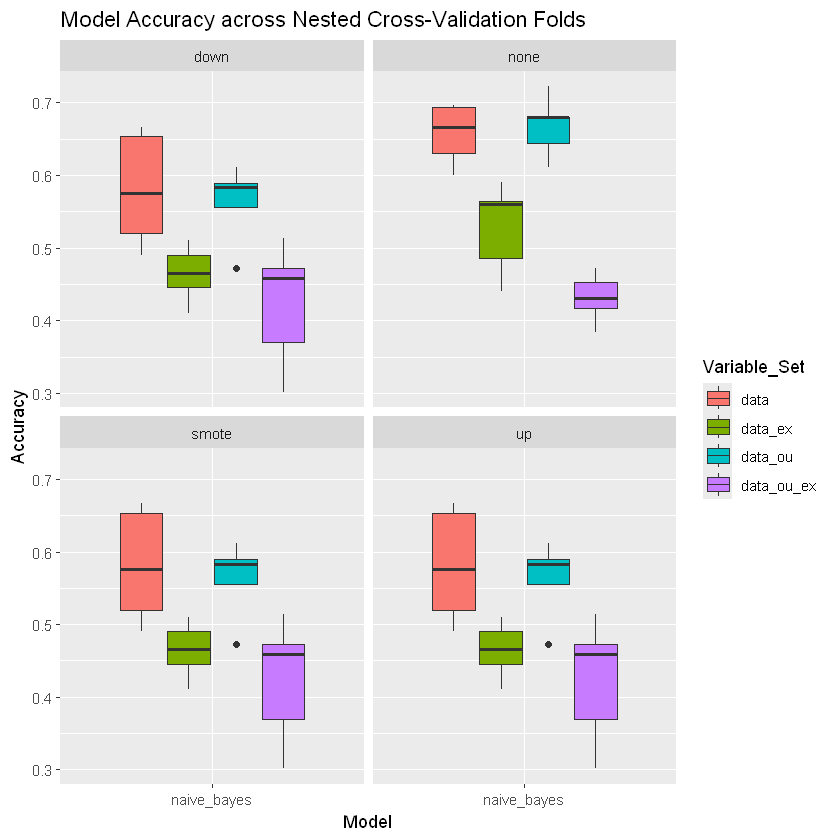

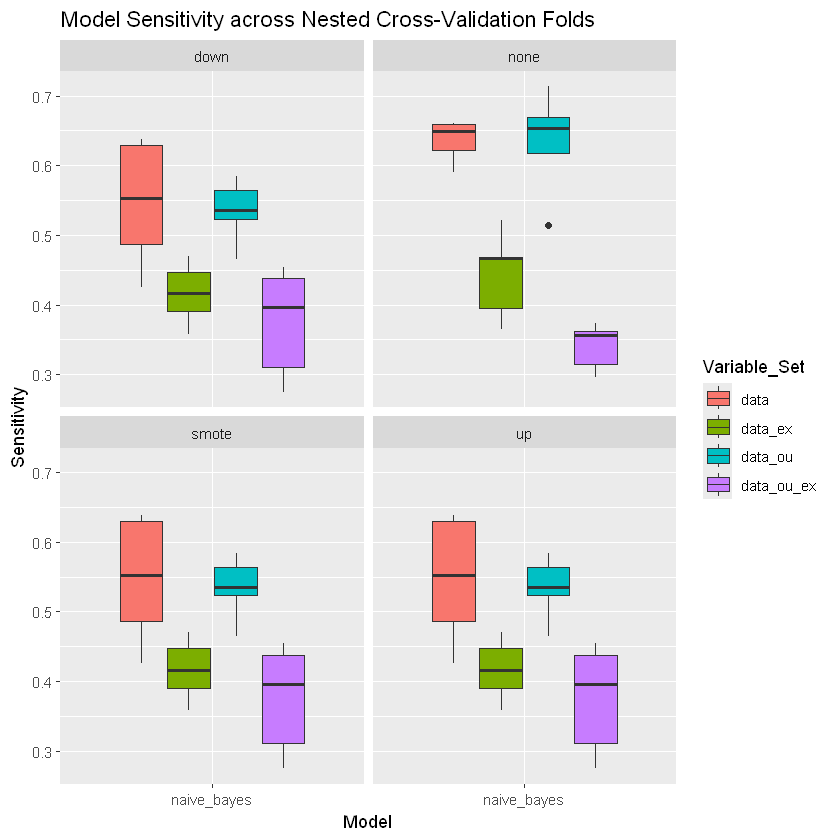

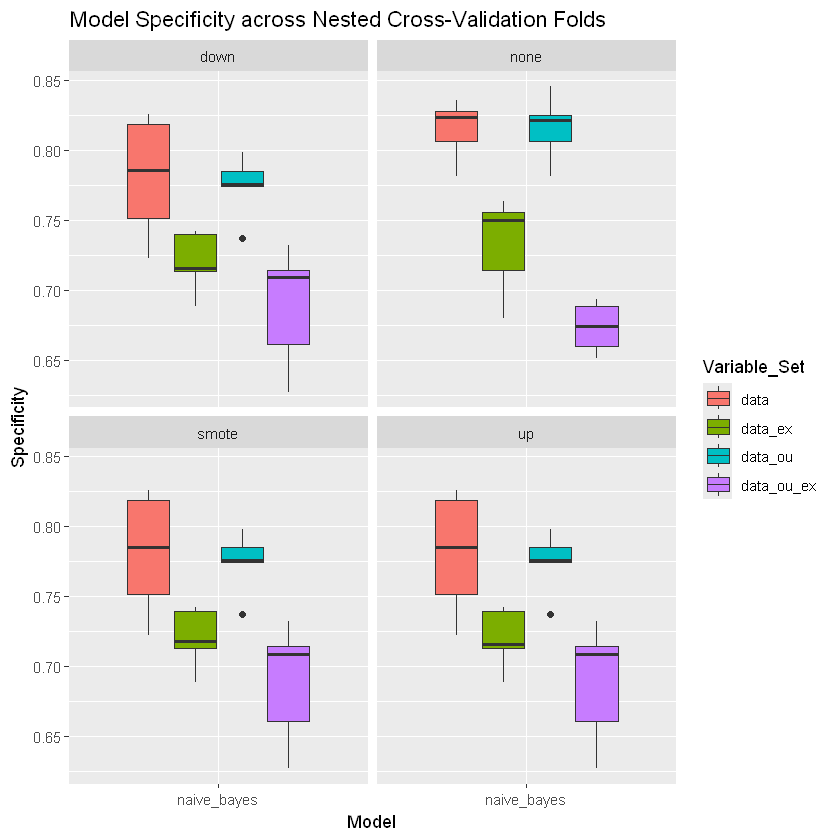

In [ ]:
# Define outer and inner folds
set.seed(123)
outer_folds <- 5
inner_folds <- 5

classification_methods <- c("multinom", "naive_bayes", "lda", "rpart", "rf")

evaluate_model <- function(model, test_data, true_labels) {
  predictions <- predict(model, newdata = test_data)
  levels <- levels(true_labels)
  metrics <- multiClassSummary(data.frame(pred = predictions, obs = true_labels), lev = levels)
  return(list(
    Accuracy = metrics["Accuracy"],
    Sensitivity = metrics["Mean_Sensitivity"],
    Specificity = metrics["Mean_Specificity"]
  ))
}

# Function to apply sampling techniques
sample_data <- function(data, method = "none") {
  if (method == "smote") {
    data_balanced <- SmoteClassif(y ~ ., dat = data, C.perc = "balance")
  } else if (method == "up") {
    data_balanced <- RandOverClassif(y ~ ., dat = data, C.perc = "balance")
  } else if (method == "down") {
    data_balanced <- RandUnderClassif(y ~ ., dat = data, C.perc = "balance")
  } else {
    # No sampling
    data_balanced <- data
  }
  return(data_balanced)
}

sampling_methods <- c("none", "up", "down", "smote") # Add your sampling methods here

results <- data.frame(Model = character(), Variable_Set = character(), Sampling_Method = character(), Fold = integer(),
                      Accuracy = numeric(), Sensitivity = numeric(), Specificity = numeric(), F1 = numeric(), row.names = NULL)

for (method in classification_methods) {
  for (variable_set in c("data", "data_ex", "data_ou", "data_ou_ex")) {
    
    data_set <- switch(variable_set,
                       "data" = data,
                       "data_ex" = data_excluded,
                       "data_ou" = data_outlier,
                       "data_ou_ex" = data_outlier_excluded)
    
    for (outer_fold in 1:outer_folds) {
      outer_train_index <- createFolds(data_set$y, k = outer_folds, list = TRUE, returnTrain = TRUE)[[outer_fold]]
      outer_train_data <- data_set[outer_train_index, ]
      outer_test_data <- data_set[-outer_train_index, ]
      
      best_inner_model <- NULL
      best_inner_accuracy <- 0
      
      for (sampling_method in sampling_methods) {
        sampled_outer_train_data <- sample_data(outer_train_data, method = sampling_method)
        
        for (inner_fold in 1:inner_folds) {
          inner_train_index <- createFolds(sampled_outer_train_data$y, k = inner_folds, list = TRUE, returnTrain = TRUE)[[inner_fold]]
          inner_train_data <- sampled_outer_train_data[inner_train_index, ]
          inner_val_data <- sampled_outer_train_data[-inner_train_index, ]
          
          model <- train(y ~ ., data = inner_train_data, method = method, trControl = trainControl(method = "cv", number = inner_folds), metric = "Accuracy")
          
          val_pred <- predict(model, newdata = inner_val_data)
          val_accuracy <- mean(val_pred == inner_val_data$y)
          
          if (val_accuracy > best_inner_accuracy) {
            best_inner_model <- model
            best_inner_accuracy <- val_accuracy
          }
        }
        
        outer_metrics <- evaluate_model(best_inner_model, outer_test_data, outer_test_data$y)
        
        results <- rbind(results, data.frame(Model = method, Variable_Set = variable_set, Sampling_Method = sampling_method, Fold = outer_fold,
                                             Accuracy = outer_metrics$Accuracy,
                                             Sensitivity = outer_metrics$Sensitivity,
                                             Specificity = outer_metrics$Specificity, row.names = NULL))
      }
    }
  }
}

# Plot results
ggplot(results, aes(x = Model, y = Accuracy, fill = Variable_Set)) +
  geom_boxplot() +
  facet_wrap(~ Sampling_Method) +
  labs(title = "Model Accuracy across Nested Cross-Validation Folds",
       x = "Model", y = "Accuracy")

ggplot(results, aes(x = Model, y = Sensitivity, fill = Variable_Set)) +
  geom_boxplot() +
  facet_wrap(~ Sampling_Method) +
  labs(title = "Model Sensitivity across Nested Cross-Validation Folds",
       x = "Model", y = "Sensitivity")

ggplot(results, aes(x = Model, y = Specificity, fill = Variable_Set)) +
  geom_boxplot() +
  facet_wrap(~ Sampling_Method) +
  labs(title = "Model Specificity across Nested Cross-Validation Folds",
       x = "Model", y = "Specificity")


In [41]:
results %>%
    group_by(Model, Variable_Set, Sampling_Method) %>%
    summarise(Accuracy = mean(Accuracy), Sensitivity = mean(Sensitivity), Specificity = mean(Specificity), .groups = 'drop') %>%
    arrange(desc(Accuracy))

Model,Variable_Set,Sampling_Method,Accuracy,Sensitivity,Specificity
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
naive_bayes,data_ou,none,0.6676560,0.6334541,0.8156827
naive_bayes,data,none,0.6573411,0.6366057,0.8147856
naive_bayes,data,down,0.5811779,0.5464405,0.7805827
naive_bayes,data,smote,0.5811779,0.5464405,0.7805827
naive_bayes,data,up,0.5811779,0.5464405,0.7805827
naive_bayes,data_ou,down,0.5622527,0.5343862,0.7740049
naive_bayes,data_ou,smote,0.5622527,0.5343862,0.7740049
naive_bayes,data_ou,up,0.5622527,0.5343862,0.7740049
naive_bayes,data_ex,none,0.5279010,0.4430148,0.7326154


until here we good

In [7]:
# Fit the GAM model
data_gam <- data
# data_gam[, excluded_vars] <- lapply(data_gam[, excluded_vars], as.factor)
preprocess_params_gam <- preProcess(data_gam[, numeric_vars], method = c("center", "scale"))
data_scaled_gam <- data_gam
data_scaled_gam[, numeric_vars] <- predict(preprocess_params_gam, data_gam[, numeric_vars])
# data_scaled_gam_ex <- data_scaled_gam %>% select(-all_of(excluded_vars))
print(head(data_scaled_gam))
continuous_vars <- paste0("s(X", 1:45, ")", collapse = " + ")
categorical_vars <- paste0("X", 46:50, collapse = " + ")
formula_string <- paste("y ~", continuous_vars, "+", categorical_vars)
# formula_string <- paste("y ~", continuous_vars)
formula_without_y <- paste("~",continuous_vars, "+", categorical_vars)
# formula_without_y <- paste("y ~", continuous_vars)
model_formula <- as.formula(formula_string)
model_formula_without_y <- as.formula(formula_without_y)

             X1           X2         X3         X4         X5          X6
274  0.05701792 -0.006212613  0.8684651  1.7573574  1.7364312 -1.45638368
158 -0.79152100  1.356519748  0.5103700  0.6180143  1.0445050 -0.02327002
312  1.72720630 -0.102797492 -0.5767724 -0.4046689  1.4484505  1.62467994
31  -0.91044364 -1.368850613  0.7412008  0.8734272 -1.5702031 -1.17817753
45  -0.51702998  0.637477274  1.5773333 -1.1343744 -0.9379826  0.88979457
178 -0.08400816 -0.269340749  0.2838925 -1.4243974 -0.1509254 -1.65518752
             X7         X8          X9       X10        X11         X12
274  1.47525264  1.3799749  0.82778438 0.4729359 -0.6519920  0.47689983
158  0.77301934 -1.7292330  0.40396904 1.3236891 -0.2083633 -0.81218428
312  1.06106790  0.1889437 -0.06914289 1.4938583  0.4544340 -0.08437091
31  -0.69702456 -1.6234543  0.45897190 1.4516650 -0.8927667  0.25312423
45  -0.02887766 -0.9349396 -1.64894163 0.9096147 -1.4738012 -0.69740850
178  0.38577375  1.3470358  0.51670405 0.2215499  

In [13]:
set.seed(123)
trainIndex <- createDataPartition(data_scaled_gam$y, p = .7, 
                                  list = FALSE, 
                                  times = 1)
data_train <- data_scaled_gam[ trainIndex,]
data_test  <- data_scaled_gam[-trainIndex,]
# Function to apply sampling techniques
sample_data <- function(data, method = "none") {
  if (method == "smote") {
    data_balanced <- SmoteClassif(y ~ ., dat = data, C.perc = "balance")
    data_balanced[, excluded_vars] <- lapply(data_balanced[, excluded_vars], round)
  } else if (method == "up") {
    data_balanced <- RandOverClassif(y ~ ., dat = data, C.perc = "balance")
  } else if (method == "down") {
    data_balanced <- RandUnderClassif(y ~ ., dat = data, C.perc = "balance")
  } else {
    # No sampling
    data_balanced <- data
  }
  return(data_balanced)
}

sampled_train_data = sample_data(data_train, method = "up")

In [ ]:
sampled_train_data$y <- as.integer(sampled_train_data$y)
sampled_train_data$y <- sampled_train_data$y - 1
sampled_train_data[, excluded_vars] <- lapply(sampled_train_data[, excluded_vars], as.factor)
# gam_model <- gam(model_formula,family=ocat(R=3),data = sampled_train_data, method = "REML",select = TRUE)
# summary(gam_model)

In [16]:
gam_model <- gam(list(model_formula,model_formula_without_y),family=multinom(K=2),data = sampled_train_data, method = "REML",select = TRUE)
summary(gam_model)

ERROR: Error in gam.fit5(x, y, sp, Sl = Sl, weights = weights, offset = offset, : vraisemblance pénalisée indéfinie dans gam.fit5 


In [72]:
    predictions <- predict(gam_model, newdata = data_test, type = "response")
    predicted_classes <- apply(predictions, 1, which.max)
    confusion_matrix <- table(data_test$y, predicted_classes)
    accuracy <- sum(diag(confusion_matrix)) / sum(confusion_matrix)


In [ ]:
# Define outer and inner folds
outer_folds <- 3
inner_folds <- 2

evaluate_gam_model <- function(model, test_data, true_labels) {
    predictions <- predict(model, newdata = test_data, type = "response")
    predicted_classes <- apply(predictions, 1, which.max)
    levels <- levels(true_labels)
    predicted_classes <- levels[predicted_classes]
    accuracy <- mean(predicted_classes == true_labels)
    return(accuracy)
}
# Function to apply sampling techniques
sample_data <- function(data, method = "none") {
  if (method == "smote") {
    data_balanced <- SmoteClassif(y ~ ., dat = data, C.perc = "balance")
  } else if (method == "up") {
    data_balanced <- RandOverClassif(y ~ ., dat = data, C.perc = "balance")
  } else if (method == "down") {
    data_balanced <- RandUnderClassif(y ~ ., dat = data, C.perc = "balance")
  } else {
    # No sampling
    data_balanced <- data
  }
  return(data_balanced)
}

results_gam <- data.frame(Fold = integer(), Accuracy = numeric(), row.names = NULL)

for (outer_fold in 1:outer_folds) {
    outer_train_index <- createFolds(data_scaled_gam$y, k = outer_folds, list = TRUE, returnTrain = TRUE)[[outer_fold]]
    outer_train_data <- data_scaled_gam[outer_train_index, ]
    outer_test_data <- data_scaled_gam[-outer_train_index, ]
    best_inner_model <- NULL
    best_inner_accuracy <- 0
    for (sampling_method in c("up", "down", "smote")) {
        sampled_outer_train_data <- sample_data(outer_train_data, method = sampling_method)
        for (inner_fold in 1:inner_folds) {
            inner_train_index <- createFolds(sampled_outer_train_data$y, k = inner_folds, list = TRUE, returnTrain = TRUE)[[inner_fold]]
            inner_train_data <- sampled_outer_train_data[inner_train_index, ]
            inner_val_data <- sampled_outer_train_data[-inner_train_index, ]
            #here goes the training of the model
            gam_model <- gam(y ~ s(X1) + s(X2), data = inner_train_data, 
                           family = multinom(K=3), 
                 method = "REML")
            val_accuracy <- evaluate_gam_model(gam_model, inner_val_data, inner_val_data$y)
            
            if (val_accuracy > best_inner_accuracy) {
                best_inner_model <- gam_model
                best_inner_accuracy <- val_accuracy
            }
        }
        }
    
    outer_accuracy <- evaluate_gam_model(best_inner_model, outer_test_data, outer_test_data$y)
    
    results_gam <- rbind(results_gam, data.frame(Fold = outer_fold, Accuracy = outer_accuracy, row.names = NULL))
}

row.names(results_gam) <- NULL


# Plot results
ggplot(results_gam, aes(x = factor(Fold), y = Accuracy)) +
    geom_boxplot() +
    labs(title = "GAM Model Accuracy across Nested Cross-Validation Folds",
         x = "Fold", y = "Accuracy")


ERROR: Error in offset[[i]]: tentative de sélection de moins d'un élément dans integerOneIndex


In [18]:
# Helper function to check levels
check_levels <- function(y_variable, fold_info) {
    n_levels <- length(levels(y_variable))
    if(n_levels != 3) {
        print(paste("Warning: Found", n_levels, "levels instead of 3 in", fold_info))
        print("Levels present:", paste(levels(y_variable), collapse=", "))
        return(FALSE)
    }
    return(TRUE)
}
# Define outer and inner folds
outer_folds <- 3
inner_folds <- 2

evaluate_gam_model <- function(model, test_data, true_labels) {
    predictions <- predict(model, newdata = test_data, type = "response")
    predicted_classes <- apply(predictions, 1, which.max)
    levels <- levels(true_labels)
    predicted_classes <- levels[predicted_classes]
    accuracy <- mean(predicted_classes == true_labels)
    return(accuracy)
}
# Function to apply sampling techniques
sample_data <- function(data, method = "none") {
  if (method == "smote") {
    data_balanced <- SmoteClassif(y ~ ., dat = data, C.perc = "balance")
  } else if (method == "up") {
    data_balanced <- RandOverClassif(y ~ ., dat = data, C.perc = "balance")
  } else if (method == "down") {
    data_balanced <- RandUnderClassif(y ~ ., dat = data, C.perc = "balance")
  } else {
    # No sampling
    data_balanced <- data
  }
  return(data_balanced)
}

# Modified main loop with checks
for (outer_fold in 1:outer_folds) {
    outer_train_index <- createFolds(data_scaled_gam_ex$y, k = outer_folds, list = TRUE, returnTrain = TRUE)[[outer_fold]]
    outer_train_data <- data_scaled_gam_ex[outer_train_index, ]
    outer_test_data <- data_scaled_gam_ex[-outer_train_index, ]
    
    # Check outer split
    if(!check_levels(outer_train_data$y, paste("outer train fold", outer_fold))) break
    if(!check_levels(outer_test_data$y, paste("outer test fold", outer_fold))) break
    
    best_inner_model <- NULL
    best_inner_accuracy <- 0
    
    for (sampling_method in c("up", "down", "smote")) {
        sampled_outer_train_data <- sample_data(outer_train_data, method = sampling_method)
        
        # Check after sampling
        if(!check_levels(sampled_outer_train_data$y, 
                        paste("sampling method", sampling_method, "outer fold", outer_fold))) break
        
        for (inner_fold in 1:inner_folds) {
            inner_train_index <- createFolds(sampled_outer_train_data$y, k = inner_folds, 
                                           list = TRUE, returnTrain = TRUE)[[inner_fold]]
            inner_train_data <- sampled_outer_train_data[inner_train_index, ]
            inner_val_data <- sampled_outer_train_data[-inner_train_index, ]
            
            # Check inner split
            if(!check_levels(inner_train_data$y, 
                           paste("inner train fold", inner_fold, "sampling", sampling_method))) break
            if(!check_levels(inner_val_data$y, 
                           paste("inner val fold", inner_fold, "sampling", sampling_method))) break
            
            # Comment out model training for now
            # gam_model <- gam(...)
            # val_accuracy <- evaluate_gam_model(...)
            
            # Placeholder for model training
            print(paste("Would train model here - inner fold:", inner_fold, 
                       "sampling:", sampling_method, "outer fold:", outer_fold))
        }
    }
    
    # Comment out accuracy evaluation for now
    # outer_accuracy <- evaluate_gam_model(...)
    # results_gam <- rbind(...)
}

[1] "Would train model here - inner fold: 1 sampling: up outer fold: 1"
[1] "Would train model here - inner fold: 2 sampling: up outer fold: 1"
[1] "Would train model here - inner fold: 1 sampling: down outer fold: 1"
[1] "Would train model here - inner fold: 2 sampling: down outer fold: 1"
[1] "Would train model here - inner fold: 1 sampling: smote outer fold: 1"
[1] "Would train model here - inner fold: 2 sampling: smote outer fold: 1"
[1] "Would train model here - inner fold: 1 sampling: up outer fold: 2"
[1] "Would train model here - inner fold: 2 sampling: up outer fold: 2"
[1] "Would train model here - inner fold: 1 sampling: down outer fold: 2"
[1] "Would train model here - inner fold: 2 sampling: down outer fold: 2"
[1] "Would train model here - inner fold: 1 sampling: smote outer fold: 2"
[1] "Would train model here - inner fold: 2 sampling: smote outer fold: 2"
[1] "Would train model here - inner fold: 1 sampling: up outer fold: 3"
[1] "Would train model here - inner fold: 2 